In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy as sp

import scipy.linalg
import scipy.optimize
# import scipy.special

from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

In [2]:
# Lx = 24 # 96 # 384 # 768 # 1536
# Ly = 2*Lx
# Lx = 12 # 96 # 384 # 768 # 1536
# Ly = 2*Lx

# Lx = 12
# Ly = 18

Lx = 6*20
Ly = int(Lx/2)

nu = 3

# tau = 1.4*(Ly/Lx*np.exp( 1.0j*np.pi/3 ) - 0.2j)
tau = 0.5*np.sqrt(3.0) * Ly/Lx * 1.0j

In [3]:
tau

0.4330127018922193j

In [4]:
def theta(z, Tau, n=0, nmax=1e5, tol=1.0e-15):
    
    if n==0:
        r = np.pi*1.0j/Tau
        s = np.exp( -r*z**2 )

        s_old = s
        for ell in np.arange(1,nmax):
            s += np.exp( -r*(ell+z)**2 )
            s += np.exp( -r*(-ell+z)**2 )

            if np.abs(s-s_old)<tol: break
            s_old = s
            if ell==nmax-1: 
                print("did not converge for z = ", z)
                return np.nan
                assert(False)

        coeff = 1.0 / np.sqrt(-1.0j*Tau)
        return coeff * s

    else:

        r = np.pi*1.0j/Tau
        arr = np.full(n+1, 0)
        arr[n]=1
        Hn = np.polynomial.hermite.Hermite( arr )

        coeff = Hn( np.sqrt(r)*z )
        exp = np.exp( -r*z**2 )
        s = coeff * exp

        s_old = s
        for ell in np.arange(1,nmax):
            coeff = Hn( np.sqrt(r)*(ell+z) )
            exp = np.exp( -r*(ell+z)**2 )
            s += coeff * exp

            coeff = Hn( np.sqrt(r)*(-ell+z) )
            exp = np.exp( -r*(-ell+z)**2 )
            s += coeff * exp

            if np.abs(s-s_old)<tol: break
            s_old = s
            if ell==nmax-1: 
                print("did not converge for z = ", z)
                return np.nan
                assert(False)

        coeff = (-1)**n * r**(n/2) / np.sqrt(-1.0j*Tau)

        return coeff * s

In [5]:
# def th1(z, n=0):
#     s = 0.0
#     for k in np.arange(n+1):
#         A = (np.pi*1.0j)**k
#         B = theta( z+0.5*tau+0.5, tau, n-k )
#         binomial = scipy.special.comb(n,k)
#         s += binomial * A * B

#     im = 0.25*np.pi*tau + np.pi*(z+0.5)
#     coeff = np.exp( 1.0j*im )

#     return -coeff * s


# def th2(z, n=0):
#     s = 0.0
#     for k in np.arange(n+1):
#         A = (np.pi*1.0j)**k
#         B = theta( z+0.5*tau, tau, n-k )
#         binomial = scipy.special.comb(n,k)
#         s += binomial * A * B

#     im = 0.25*np.pi*tau + np.pi*(z)
#     coeff = np.exp( 1.0j*im )

#     return -coeff * s

# def th3(z, n=0):
#     return theta(z, tau, n)

# def th4(z, n=0):
#     return theta(z+0.5, tau, n)

In [6]:
def th1(z, n=0):
    s = 0.0
    for k in np.arange(n+1):
        A = (np.pi*1.0j)**k
        B = theta( z+0.5*tau+0.5, tau, n-k )
        binomial = scipy.special.comb(n,k)
        s += binomial * A * B

    im = 0.25*np.pi*tau + np.pi*(z+0.5)
    coeff = np.exp( 1.0j*im )

    return -coeff * s


def th2(z, n=0):
    s = 0.0
    for k in np.arange(n+1):
        A = (np.pi*1.0j)**k
        B = theta( z+0.5*tau, tau, n-k )
        binomial = scipy.special.comb(n,k)
        s += binomial * A * B

    im = 0.25*np.pi*tau + np.pi*(z)
    coeff = np.exp( 1.0j*im )

    return coeff * s

def th3(z, n=0):
    return theta(z, tau, n)

def th4(z, n=0):
    return theta(z+0.5, tau, n)

In [7]:
th1p0 = th1(0, 1)
th20 = th2(0)
th30 = th3(0)
th40 = th4(0)

e1 = 1.0/3.0 * (np.pi)**2 * (th30**4 + th40**4)
e2 = 1.0/3.0 * (np.pi)**2 * (th20**4 - th40**4)
e3 = -1.0/3.0 * (np.pi)**2 * (th20**4 + th30**4)

In [8]:
def P(z):
    res = 0.0
    
    tmp = np.pi * th20*th30*th4(z)/th1(z)
    res += tmp**2
    
    tmp = th20**4 + th30**4
    tmp *= np.pi**2/3.0
    res -= tmp
    
    return res

def dP(z):
    coeff = (np.pi * th20*th30)**2
    
    f1 = th4(z) * th4(z,1) / th1(z)**2
    f2 = th4(z)**2 * th1(z,1) / th1(z)**3

    res = 2.0 * coeff * (f1-f2)
    
    return res

def ddP(z):    
    coeff = (np.pi * th20*th30)**2
    
    f1 = ( th4(z,1)**2 + th4(z) * th4(z,2) ) / th1(z)**2
    f2 = th4(z) * th4(z,1) * th1(z,1) / th1(z)**3
    f3 = th4(z)**2 * th1(z,2) / th1(z)**3
    f4 = th4(z)**2 * th1(z,1)**2 / th1(z)**4

    res = 2.0 * coeff * (f1 
                         - 4.0*f2 -f3 + 3.0*f4 )
    
    return res

In [9]:
# eps= 0.001
# zz= 0.2 + 0.3*1.0j

# print( dP(zz) )
# print( (P(zz+eps)-P(zz-eps))/(2.0*eps) )

# print( ddP(zz) )
# print( (dP(zz+eps)-dP(zz-eps))/(2.0*eps) )

In [10]:
def zeta(z):
    return th1(z,1)/th1(z) + 2.0*eta1*z

In [11]:
zz=0.43+0.238*1.0j

# zz=0.1 + 0.1j

In [12]:
tau

0.4330127018922193j

In [13]:
eta1 = -1.0/6.0 * th1(0, n=3)/th1(0, n=1)

In [14]:
zeta( 0.5 )

(-1.5176791397064244-1.046833277524947e-15j)

In [15]:
eta1

(-1.5176791397064244-2.1373441118981565e-16j)

In [16]:
def P2(z):
    return th1p0/th20 * th2(z)/th1(z)

def P3(z):
    return th1p0/th30 * th3(z)/th1(z)

def P4(z):
    return th1p0/th40 * th4(z)/th1(z)

# def P2Alt(z):
#     return np.sqrt( P(z)-e1 )
# def P3Alt(z):
#     return np.sqrt( P(z)-e2 )
# def P4Alt(z):
#     return np.sqrt( P(z)-e3 )

In [17]:
def dedekind( t ):
    return np.exp( np.pi*1.0j*t/12.0 ) * theta(0.5*(t+1.0), 3.0*t)

In [18]:
def dP2(z):
    return th1p0/th20 * ( th2(z,1)/th1(z) - th2(z)*th1(z,1)/th1(z)**2 )

def ddP2(z):
    return th1p0/th20 * ( th2(z,2)/th1(z) - 2.0*th2(z,1)*th1(z,1)/th1(z)**2 - th2(z)*th1(z,2)/th1(z)**2 + 2.0*th2(z)*th1(z,1)**2/th1(z)**3 )

def dP3(z):
    return th1p0/th30 * ( th3(z,1)/th1(z) - th3(z)*th1(z,1)/th1(z)**2 )

def ddP3(z):
    return th1p0/th30 * ( th3(z,2)/th1(z) - 2.0*th3(z,1)*th1(z,1)/th1(z)**2 - th3(z)*th1(z,2)/th1(z)**2 + 2.0*th3(z)*th1(z,1)**2/th1(z)**3 )

def dP4(z):
    return th1p0/th40 * ( th4(z,1)/th1(z) - th4(z)*th1(z,1)/th1(z)**2 )

def ddP4(z):
    return th1p0/th40 * ( th4(z,2)/th1(z) - 2.0*th4(z,1)*th1(z,1)/th1(z)**2 - th4(z)*th1(z,2)/th1(z)**2 + 2.0*th4(z)*th1(z,1)**2/th1(z)**3 )

In [19]:
def TTconn(z):
    return -0.25 * ( dP3(z)**2 - ddP3(z)*P3(z) )

In [20]:
def Dth1(z):
    im = 0.25*np.pi*tau + np.pi*(z+0.5)
    coeff = np.exp( 1.0j*im )

    s = 0.0
    s += 0.25*1.0j*np.pi * th1(z)
    s -= 0.5*coeff * th3(z+0.5*tau+0.5, 1)
    s -= 1.0/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau+0.5, 2)
    return s

def Dth2(z):
    im = 0.25*np.pi*tau + np.pi*(z)
    coeff = np.exp( 1.0j*im )

    s = 0.0
    s += 0.25*1.0j*np.pi * th2(z)
    s += 0.5*coeff * th3(z+0.5*tau, 1)
    s += 1.0/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau, 2)
    return s

def Dth3(z):
    return 1.0/(4.0*np.pi*1.0j) * th3(z, 2)

def Dth4(z):
    return 1.0/(4.0*np.pi*1.0j) * th4(z, 2)

In [21]:
zz=0.2+0.3j
Dth2(zz)

(6.018441040001413-0.8432912287448375j)

In [22]:
def dDth1(z):
    im = 0.25*np.pi*tau + np.pi*(z+0.5)
    coeff = np.exp( 1.0j*im )

    s = 0.0
    s += 0.25*1.0j*np.pi * th1(z, 1)
    s -= 0.5*np.pi*1.0j*coeff * th3(z+0.5*tau+0.5, 1)
    s -= 0.5*coeff * th3(z+0.5*tau+0.5, 2)
    s -= np.pi*1.0j/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau+0.5, 2)
    s -= 1.0/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau+0.5, 3)
    return s

def dDth2(z):
    im = 0.25*np.pi*tau + np.pi*(z)
    coeff = np.exp( 1.0j*im )

    s = 0.0
    s += 0.25*1.0j*np.pi * th2(z, 1)
    s += 0.5*np.pi*1.0j*coeff * th3(z+0.5*tau, 1)
    s += 0.5*coeff * th3(z+0.5*tau, 2)
    s += np.pi*1.0j/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau, 2)
    s += 1.0/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau, 3)
    return s

def dDth3(z):
    return 1.0/(4.0*np.pi*1.0j) * th3(z, 3)

def dDth4(z):
    return 1.0/(4.0*np.pi*1.0j) * th4(z, 3)

In [23]:
eps=1.0e-3
zz

(0.2+0.3j)

In [24]:
print( (Dth1(zz+eps)-Dth1(zz-eps))/(2.0*eps) )
print( dDth1(zz) )

(-47.71524677224947+13.598764156508736j)
(-47.71598049369899+13.59872747732637j)


In [25]:
print( (Dth2(zz+eps)-Dth2(zz-eps))/(2.0*eps) )
print( dDth2(zz) )

(-20.13308834418215-53.36436739651096j)
(-20.133611270281335-53.365115031202265j)


In [26]:
print( (Dth3(zz+eps)-Dth3(zz-eps))/(2.0*eps) )
print( dDth3(zz) )

(-14.523889628238695-49.47764428329973j)
(-14.524490163394603-49.478291631541545j)


In [27]:
print( (Dth4(zz+eps)-Dth4(zz-eps))/(2.0*eps) )
print( dDth4(zz) )

(-33.47628587914819+14.567602443243066j)
(-33.47694864034921+14.567331104963328j)


In [28]:
def DP2(z):
    tmp1 = dDth1(0)/th20 * th2(z)/th1(z)
    tmp2 = -th1p0*Dth2(0)/th20**2 * th2(z)/th1(z)
    tmp3 = th1p0/th20 * Dth2(z)/th1(z)
    tmp4 = -th1p0/th20 * th2(z)*Dth1(z)/th1(z)**2
    return tmp1+tmp2+tmp3+tmp4

def DP3(z):
    tmp1 = dDth1(0)/th30 * th3(z)/th1(z)
    tmp2 = -th1p0*Dth3(0)/th30**2 * th3(z)/th1(z)
    tmp3 = th1p0/th30 * Dth3(z)/th1(z)
    tmp4 = -th1p0/th30 * th3(z)*Dth1(z)/th1(z)**2
    return tmp1+tmp2+tmp3+tmp4

def DP4(z):
    tmp1 = dDth1(0)/th40 * th4(z)/th1(z)
    tmp2 = -th1p0*Dth4(0)/th40**2 * th4(z)/th1(z)
    tmp3 = th1p0/th40 * Dth4(z)/th1(z)
    tmp4 = -th1p0/th40 * th4(z)*Dth1(z)/th1(z)**2
    return tmp1+tmp2+tmp3+tmp4

In [29]:
def Tepseps2_analytic(w0, w1, w2):

    p = P2(w1-w2)
    cp = np.conj(P2(w1-w2))
    dp = dP2(w1-w2)
    Dp = DP2(w1-w2)

    epseps = p*cp

    tmp1 = 0.5 * ( P(w1-w0) + 2.0*eta1 ) * epseps
    tmp2 = 1.0 * ( - zeta(w1-w0) + 2.0*eta1*(w1-w0) ) * dp*cp

    tmp3 = 0.5 * ( P(w2-w0) + 2.0*eta1 ) * epseps
    tmp4 = -1.0 * ( - zeta(w2-w0) + 2.0*eta1*(w2-w0) ) * dp*cp

    tmp5 = 2.0*np.pi*1.0j * Dp*cp

    tmp6 = -0.25*e1 * epseps
    
    # return tmp1 + tmp2 + tmp3 + tmp4 + tmp5 + tmp6
    return tmp1 + tmp2 + tmp3 + tmp4 + tmp5

def Tepseps3_analytic(w0, w1, w2):

    p = P3(w1-w2)
    cp = np.conj(P3(w1-w2))
    dp = dP3(w1-w2)
    Dp = DP3(w1-w2)

    epseps = p*cp

    tmp1 = 0.5 * ( P(w1-w0) + 2.0*eta1 ) * epseps
    tmp2 = 1.0 * ( - zeta(w1-w0) + 2.0*eta1*(w1-w0) ) * dp*cp

    tmp3 = 0.5 * ( P(w2-w0) + 2.0*eta1 ) * epseps
    tmp4 = -1.0 * ( - zeta(w2-w0) + 2.0*eta1*(w2-w0) ) * dp*cp

    tmp5 = 2.0*np.pi*1.0j * Dp*cp

    tmp6 = -0.25*e2 * epseps
    
    # return tmp1 + tmp2 + tmp3 + tmp4 + tmp5 + tmp6
    return tmp1 + tmp2 + tmp3 + tmp4 + tmp5

def Tepseps4_analytic(w0, w1, w2):

    p = P4(w1-w2)
    cp = np.conj(P4(w1-w2))
    dp = dP4(w1-w2)
    Dp = DP4(w1-w2)

    epseps = p*cp

    tmp1 = 0.5 * ( P(w1-w0) + 2.0*eta1 ) * epseps
    tmp2 = 1.0 * ( - zeta(w1-w0) + 2.0*eta1*(w1-w0) ) * dp*cp

    tmp3 = 0.5 * ( P(w2-w0) + 2.0*eta1 ) * epseps
    tmp4 = -1.0 * ( - zeta(w2-w0) + 2.0*eta1*(w2-w0) ) * dp*cp

    tmp5 = 2.0*np.pi*1.0j * Dp*cp

    tmp6 = -0.25*e3 * epseps
    
#    return tmp1 + tmp2 + tmp3 + tmp4 + tmp5 + tmp6
    return tmp1 + tmp2 + tmp3 + tmp4 + tmp5

In [30]:
tau

0.4330127018922193j

In [31]:
th1p0

(3.5950522673057392-2.7897186880564283e-16j)

In [32]:
th30

(1.5218186452616613+0j)

In [33]:
eta1 = -1.0/6.0 * th1(0, n=3)/th1(0, n=1)

In [34]:
zz=0.1+0.1j

In [35]:
def pt(z):
    return dP3(z)**2 - d

$$
\xi_P = r \, \psi_P \\
r = \sqrt{\frac{3\sqrt{3}}{2} a}
$$
And that:
$$
\eta(z) \equiv \sqrt{2\pi} \psi_1(z),
\quad
\bar\eta(z) \equiv i\sqrt{2\pi} \psi_2(\bar z),
$$
for which:
$$
\langle \eta(z) \eta(0)\rangle = 1/z,
\quad
\langle \bar\eta(\bar z) \bar\eta(0)\rangle = 1/{\bar z}.
$$

In [36]:
kappa = 2.0/3.0
cos = np.cos( np.pi/6.0 )
B = cos / ( 1.0 - kappa**2 * cos**2 )
alat = 1.0/Lx

tanhbeta = kappa*cos

alat = 1.0/Lx
r = np.sqrt(3.0/2.0 * np.sqrt(3.0) * alat) # 

## $\psi \psi$ correlator

In [37]:
# lw1 = 1.062080926639608e+02
# lw2 = 1.704561639486924e+02
# lw3 = 1.717731205478864e+02
# lw4 = 1.718077888669185e+02

In [38]:
# numer = np.exp(lw1-lw3) * (xixi001[0,2] - 0.75)

In [39]:
# nu=1
# xixi001 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"xixi00.dat")

# nu=2
# xixi002 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"xixi00.dat")

# nu=3
# xixi003 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"xixi00.dat")

# nu=4
# xixi004 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"xixi00.dat")

In [40]:
# subt_spin = 0.0035990570805810584

In [41]:
# print( xixi001[0,2] )
# print( xixi002[0,2] )
# print( xixi003[0,2] )
# print( xixi004[0,2] )

In [42]:
# tot = (-xixi001[0] + xixi002[0] + xixi003[0] + xixi004[0]) / 3.0

In [43]:
xixi00 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"xixi00.dat")
xixi01 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"xixi01.dat")
xixi10 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"xixi10.dat")
xixi11 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"xixi11.dat")

$$
\langle \xi_{O,i} \xi_{P,j} \rangle
=
-{D^{-1}_{P,j}}^{O,k} \epsilon_{ki}
$$
or
$$
{D^{-1}_{P,j}}^{O,k} 
=
\langle \xi_{P,j} \xi_{O,i} \rangle
\epsilon^{ik}.
$$
Now that:
$$
\langle \xi_{P,j} \xi_{O,i} \rangle
=
r^2 
\langle \psi_{P,j} \psi_{O,i} \rangle
$$

In [44]:
# tau = 1.4*(Ly/Lx*np.exp( 1.0j*np.pi/3 ) - 0.2j)
tmp = np.array([[ [xx, yy, P3(xx+tau*yy) ] for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp2 = tmp.flatten()
etaeta_analytic=np.array(np.split(tmp2, tmp2.shape[0]/3))

$$
(2\pi/r^2){D^{-1}_{P,0}}^{O,1} 
=
2\pi
\langle \psi_{P,0} \psi_{O,0} \rangle
\epsilon^{01}
=
\frac{1}{z}.
$$

In [45]:
tmpx = xixi00.T[0]
tmpy = xixi00.T[1]
tmpzr = xixi00.T[2]
tmpzi = xixi00.T[3]
res_ = []

for i in range(len(xixi01.T[0])):
    res_.append( [ tmpx[i]/Lx, tmpy[i]/Lx, 2.0*np.pi*(tmpzr[i]+1.0j*tmpzi[i])/r**2 ] )
etaetabar = np.array(res_)

In [46]:
np.real( etaetabar[0,2] )

229.17478345677716

In [47]:
ll = [
    [1, 174.10584522310768],
    [2, 174.12473896648487], # 
    [3, 174.12473896648487],
    [4, 174.1247389664851],
]

In [48]:
# numer = np.abs(th20) * ll[1][1] + np.abs(th30) * ll[2][1] + np.abs(th40) * ll[3][1]
# denom = np.abs(th20) + np.abs(th30) + np.abs(th40)
# numer / denom

In [49]:
eta = dedekind( tau )

In [50]:
2.0*np.pi * np.abs(eta)**3 / ( np.abs(th20) + np.abs(th30) + np.abs(th40) )

1.0170288283834383

In [51]:
# plt.close()
# fig = plt.figure(figsize=plt.figaspect(1.0))

# #################

# ax = fig.add_subplot(111, projection='3d')
# ax.view_init(elev=90., azim=90)

# ax.scatter(etaetabar.T[0], etaetabar.T[1], np.log(np.real(etaetabar.T[2])), c='r', marker='o', label="+", alpha=0.2)

# ax.scatter(etaeta.T[0], etaeta.T[1], np.log(np.real(etaeta.T[2])), c='b', marker='o', label="+", alpha=0.2)

# # ax.scatter(etaetabar.T[0], etaetabar.T[1], np.log(-np.real(etaetabar.T[2])), c='b', marker='o', label="-", alpha=0.2)
# ax.set_zlim( -5, 5)

# ax.legend()

# ################

In [52]:
tmpx = xixi01.T[0]
tmpy = xixi01.T[1]
tmpzr = xixi01.T[2]
tmpzi = xixi01.T[3]
res_ = []

for i in range(len(xixi01.T[0])):
    res_.append( [ tmpx[i]/Lx, tmpy[i]/Lx, 2.0*np.pi*(tmpzr[i]+1.0j*tmpzi[i])/r**2 ] )
etaeta = np.array(res_)

In [53]:
Lxeff = int(2*Lx/3)
def rearrange(input):
    res_ = [] 
    for i in range(int(input.shape[0]/Lxeff)):
        tmp = input[i*Lxeff:(i+1)*Lxeff]
        reg = tmp.T[2][:-int((i+1)/3)]
        wrap = tmp.T[2][-int((i+1)/3):]
        sign = -1
        if i<=2: sign*=-1
        new = np.concatenate((sign*wrap, reg), axis=0)
        ordered = np.array([ tmp.T[0], tmp.T[1], new ]).T
        res_.append(ordered)
    res = np.array(res_)
    return res

In [54]:
etaeta2 = rearrange(etaeta)

/tmp/ipykernel_15744/287993832.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(etaeta2.T[0], etaeta2.T[1], np.log(np.real(etaeta2.T[2])), c='r', marker='o', label="+", alpha=0.2)
/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_15744/287993832.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(etaeta2.T[0], etaeta2.T[1], np.log(-np.real(etaeta2.T[2])), c='b', marker='o', label="-", alpha=0.2)
/tmp/ipykernel_15744/287993832.py:23: Runt

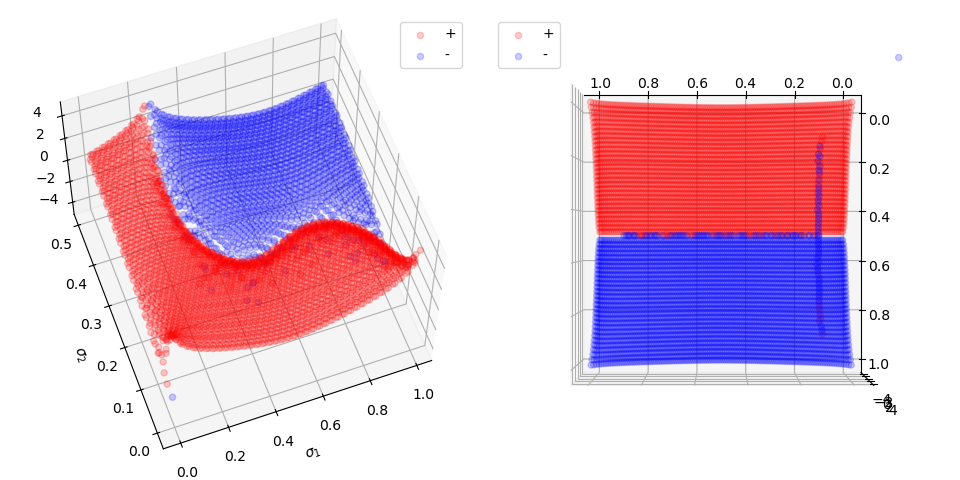

In [55]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=60., azim=-110)

ax.scatter(etaeta2.T[0], etaeta2.T[1], np.log(np.real(etaeta2.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(etaeta2.T[0], etaeta2.T[1], np.log(-np.real(etaeta2.T[2])), c='b', marker='o', label="-", alpha=0.2)
ax.set_zlim( -5, 5)

ax.set_xlabel("$\sigma_1$")
ax.set_ylabel("$\sigma_2$")

ax.legend()

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=90)
ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
           np.log(np.real(etaeta_analytic.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
           np.log(np.real(-etaeta_analytic.T[2])), c='b', marker='o', label="-", alpha=0.2)
ax.set_zlim( -5, 5)

ax.legend()

# ax.set_

#################

fig.tight_layout()

# plt.savefig('../plt/re_xixi_above.pdf',bbox_inches='tight')

/tmp/ipykernel_15040/3732800781.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(etaeta.T[0], etaeta.T[1], np.log(np.imag(etaeta.T[2])), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_15040/3732800781.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(etaeta.T[0], etaeta.T[1], np.log(-np.imag(etaeta.T[2])), c='b', marker='o', label="-", alpha=0.2)
/tmp/ipykernel_15040/3732800781.py:20: RuntimeWarning: invalid value encountered in log
  np.log(np.imag(etaeta_analytic.T[2])), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_15040/3732800781.py:22: RuntimeWarning: invalid value encountered in log
  np.log(np.imag(-etaeta_analytic.T[2])), c='b', marker='o', label="-", alpha=0.2)


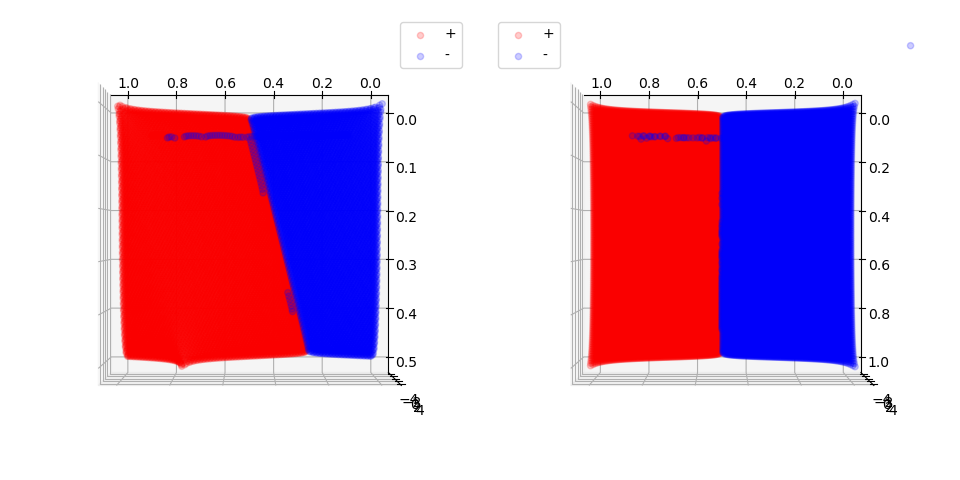

In [56]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(etaeta.T[0], etaeta.T[1], np.log(np.imag(etaeta.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(etaeta.T[0], etaeta.T[1], np.log(-np.imag(etaeta.T[2])), c='b', marker='o', label="-", alpha=0.2)
ax.set_zlim( -5, 5)

ax.legend()

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=90)
ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
           np.log(np.imag(etaeta_analytic.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
           np.log(np.imag(-etaeta_analytic.T[2])), c='b', marker='o', label="-", alpha=0.2)
ax.set_zlim( -5, 5)

ax.legend()

#################

fig.tight_layout()

# plt.savefig('../plt/im_xixi_above.pdf',bbox_inches='tight')

(0.01, 10000.0)

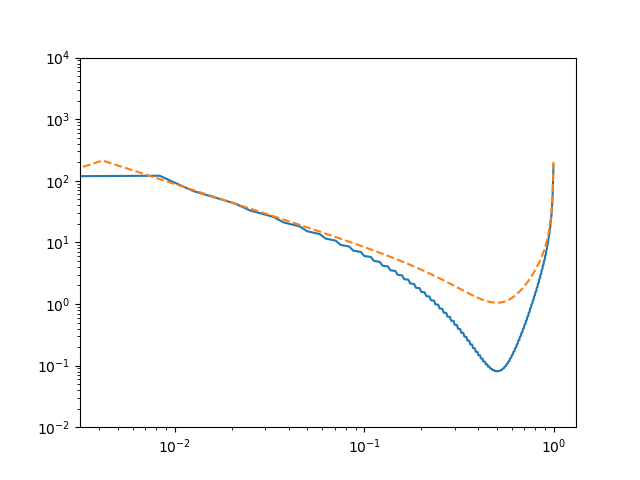

In [57]:
# tau = (Ly/Lx*np.exp( 1.0j*np.pi/3 ) - 0.21 - 0.18j)
tau = 0.6*np.sqrt(3.0) * Ly/Lx * 1.0j

tmp = np.array([[ [xx, yy, P3(xx+tau*yy) ] for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp2 = tmp.flatten()
etaeta_analytic=np.array(np.split(tmp2, tmp2.shape[0]/3))

plt.close()

plt.plot( 
    etaeta.T[0][:int(Lx*2/3)], 
    etaeta.T[2][:int(Lx*2/3)],
    label="numeric"
        )

plt.plot(
    etaeta_analytic.T[0][:int(Lx)], 
    etaeta_analytic.T[2][:int(Lx)],
    label="analytic", 
    ls="dashed"
)

plt.yscale("log")
plt.xscale("log")

plt.ylim(1.0e-2, 1.0e4)

# plt.savefig('../plt/xixi_slice.pdf',bbox_inches='tight')

In [58]:
1.111111111111111/1.481481481481484e+00

0.7499999999999986

In [59]:
1.0/3.0

0.3333333333333333

In [60]:
numer = 3.0 * 1.111111111111111 - 0.6666666666666666666666 
denom = 3.0 * 1.481481481481484e+00

In [61]:
numer/denom

0.599999999999999

In [62]:
kappaB = 0.8660254037844385

In [63]:
2.0 * 1.1491213362587276 / kappaB / 3.0

0.8845940170940253

## $TT$ correlator

In [173]:
tt0000 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0000.dat")
tt0001 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0001.dat")
tt0002 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0002.dat")

tt0010 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0010.dat")
tt0011 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0011.dat")
tt0012 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0012.dat")

tt0020 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0020.dat")
tt0021 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0021.dat")
tt0022 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0022.dat")

#

tt0100 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0100.dat")
tt0101 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0101.dat")
tt0102 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0102.dat")

tt0110 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0110.dat")
tt0111 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0111.dat")
tt0112 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0112.dat")

tt0120 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0120.dat")
tt0121 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0121.dat")
tt0122 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0122.dat")

#

tt0200 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0200.dat")
tt0201 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0201.dat")
tt0202 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0202.dat")

tt0210 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0210.dat")
tt0211 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0211.dat")
tt0212 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0212.dat")

tt0220 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0220.dat")
tt0221 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0221.dat")
tt0222 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt0222.dat")

#

tt1000 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1000.dat")
tt1001 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1001.dat")
tt1002 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1002.dat")

tt1010 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1010.dat")
tt1011 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1011.dat")
tt1012 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1012.dat")

tt1020 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1020.dat")
tt1021 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1021.dat")
tt1022 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1022.dat")

#

tt1100 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1100.dat")
tt1101 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1101.dat")
tt1102 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1102.dat")

tt1110 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1110.dat")
tt1111 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1111.dat")
tt1112 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1112.dat")

tt1120 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1120.dat")
tt1121 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1121.dat")
tt1122 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1122.dat")

#

tt1200 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1200.dat")
tt1201 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1201.dat")
tt1202 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1202.dat")

tt1210 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1210.dat")
tt1211 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1211.dat")
tt1212 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1212.dat")

tt1220 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1220.dat")
tt1221 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1221.dat")
tt1222 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt1222.dat")

#

tt2000 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2000.dat")
tt2001 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2001.dat")
tt2002 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2002.dat")

tt2010 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2010.dat")
tt2011 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2011.dat")
tt2012 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2012.dat")

tt2020 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2020.dat")
tt2021 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2021.dat")
tt2022 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2022.dat")

#

tt2100 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2100.dat")
tt2101 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2101.dat")
tt2102 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2102.dat")

tt2110 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2110.dat")
tt2111 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2111.dat")
tt2112 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2112.dat")

tt2120 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2120.dat")
tt2121 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2121.dat")
tt2122 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2122.dat")

#

tt2200 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2200.dat")
tt2201 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2201.dat")
tt2202 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2202.dat")

tt2210 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2210.dat")
tt2211 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2211.dat")
tt2212 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2212.dat")

tt2220 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2220.dat")
tt2221 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2221.dat")
tt2222 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"tt2222.dat")

FileNotFoundError: ../data/Lx120Ly60nu3tt0000.dat not found.

In [22]:
tmp = np.array([[ [xx, yy, TTconn(xx+tau*yy) ] for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp2 = tmp.flatten()
TTconn_analytic=np.array(np.split(tmp2, tmp2.shape[0]/3))

In [16]:
tmp = tt0000 - 0.5*(tt0001+tt0002) - 0.5*(tt0100+tt0200) + 0.25*(tt0101+tt0102+tt0201+tt0202)
TxxTxx = (2.0*np.pi)**2/(9.0*alat**2) * 1.0/r**4 * np.array(tmp)

/tmp/ipykernel_97708/2722524989.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(TxxTxx.T[6]), c='b', marker='o', label="+")
/tmp/ipykernel_97708/2722524989.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(-TxxTxx.T[6]), c='r', marker='o', label="-")
/tmp/ipykernel_97708/2722524989.py:23: RuntimeWarning: invalid value encountered in log
  ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.real(TTconn_analytic.T[2])),
/home/nobu68/.local/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/nobu68/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_97708/2722524989.py:25: RuntimeWarning: inv

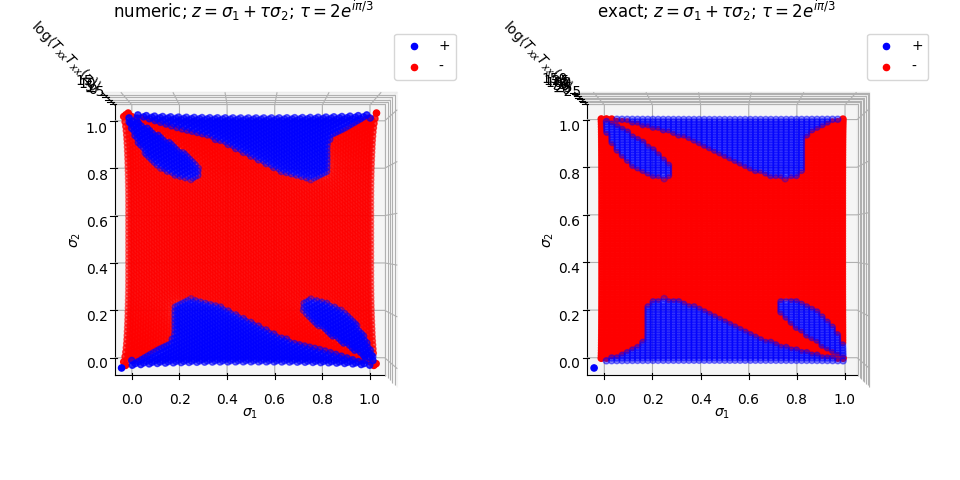

In [17]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(TxxTxx.T[6]), c='b', marker='o', label="+")
ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(-TxxTxx.T[6]), c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.real(TTconn_analytic.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.real(TTconn_analytic.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

#################

fig.tight_layout()
plt.savefig('../plt/TxxTxx_above.pdf',bbox_inches='tight')

/tmp/ipykernel_97708/2773931291.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(TxxTxx.T[6]), c='b', marker='o', label="+")
/tmp/ipykernel_97708/2773931291.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(-TxxTxx.T[6]), c='r', marker='o', label="-")
/tmp/ipykernel_97708/2773931291.py:25: RuntimeWarning: invalid value encountered in log
  ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.real(TTconn_analytic.T[2])),
/home/nobu68/.local/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/nobu68/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_97708/2773931291.py:27: RuntimeWarning: inv

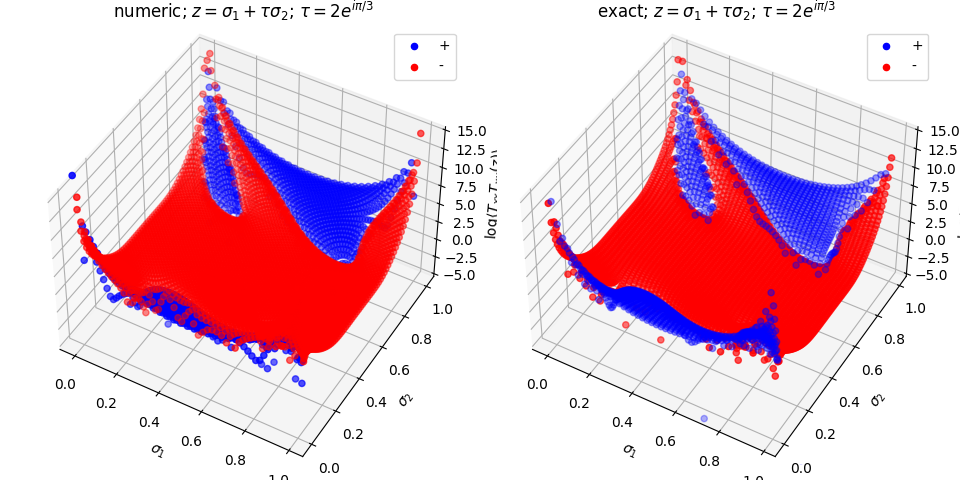

In [18]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=45., azim=-60)

ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(TxxTxx.T[6]), c='b', marker='o', label="+")
ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(-TxxTxx.T[6]), c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

ax.set_zlim( -5, 15)

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=45., azim=-60)

ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.real(TTconn_analytic.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.real(TTconn_analytic.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

ax.set_zlim( -5, 15)

#################

fig.tight_layout()
plt.savefig('../plt/TxxTxx_slant.pdf',bbox_inches='tight')

/home/nobu68/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


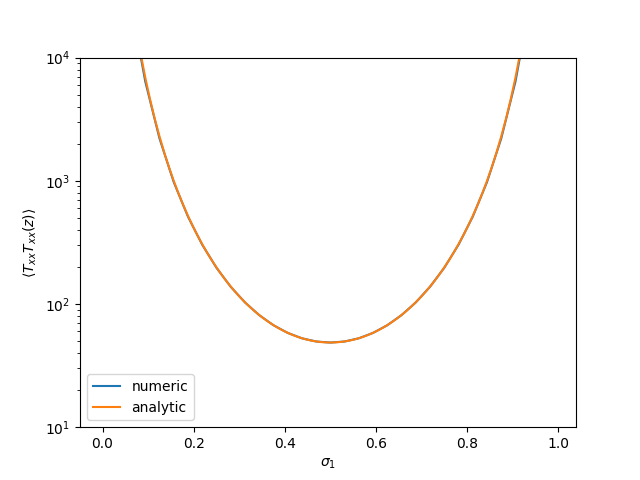

In [25]:
plt.close()

plt.plot( tt0000.T[0][:int(Lx/3)]/Lx, TxxTxx.T[6][:int(Lx/3)], label="numeric")
plt.plot( TTconn_analytic.T[0][:Lx], 2.0 * np.real(TTconn_analytic.T[2][:Lx]), label="analytic")

plt.ylim(1e1,1.0e4)
plt.legend()

plt.xlabel("$\\sigma_1$")
plt.ylabel("$\\langle T_{xx}T_{xx}(z) \\rangle$")

plt.yscale("log")
plt.savefig('../plt/TxxTxx_slice.pdf',bbox_inches='tight')

In [20]:
tmp1 = tt0022 - 0.5*(tt0020+tt0021) - 0.5*(tt0122+tt0222) + 0.25*(tt0120+tt0121+tt0220+tt0221)
tmp2 = tt0011 - 0.5*(tt0012+tt0010) - 0.5*(tt0111+tt0211) + 0.25*(tt0112+tt0110+tt0212+tt0210)
TxxTxy = (2.0*np.pi)**2 * 1.0 / (9.0* np.sqrt(3.0) * alat**2) * 1.0/r**4 * (np.array(tmp1) - np.array(tmp2))

/tmp/ipykernel_8370/2788606806.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(TxxTxy.T[6]), c='b', marker='o', label="+")
/tmp/ipykernel_8370/2788606806.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(-TxxTxy.T[6]), c='r', marker='o', label="-")
/tmp/ipykernel_8370/2788606806.py:24: RuntimeWarning: invalid value encountered in log
  ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])),
/home/nobu68/.local/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/nobu68/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_8370/2788606806.py:26: RuntimeWarning: invali

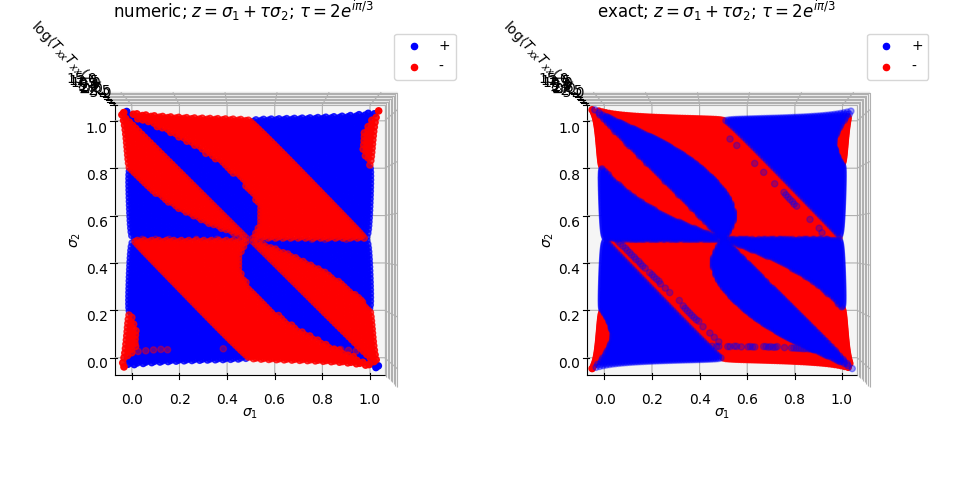

In [33]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(TxxTxy.T[6]), c='b', marker='o', label="+")
ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(-TxxTxy.T[6]), c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim( -5, 15)

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.imag(TTconn_analytic.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim( -5, 15)

#################

fig.tight_layout()
plt.savefig('../plt/TxxTxy_above.pdf',bbox_inches='tight')

/tmp/ipykernel_8370/2413736537.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(TxxTxy.T[6]), c='b', marker='o', label="+")
/tmp/ipykernel_8370/2413736537.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(-TxxTxy.T[6]), c='r', marker='o', label="-")
/tmp/ipykernel_8370/2413736537.py:24: RuntimeWarning: invalid value encountered in log
  ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])),
/home/nobu68/.local/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/nobu68/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_8370/2413736537.py:26: RuntimeWarning: invali

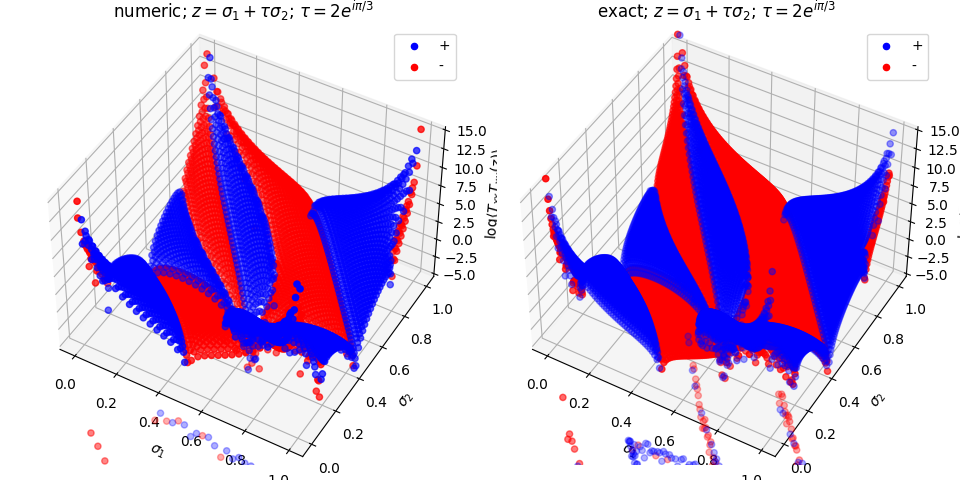

In [34]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=45., azim=-60)

ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(TxxTxy.T[6]), c='b', marker='o', label="+")
ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(-TxxTxy.T[6]), c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim( -5, 15)

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=45., azim=-60)

ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.imag(TTconn_analytic.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim( -5, 15)

#################

fig.tight_layout()
plt.savefig('../plt/TxxTxy_slant.pdf',bbox_inches='tight')

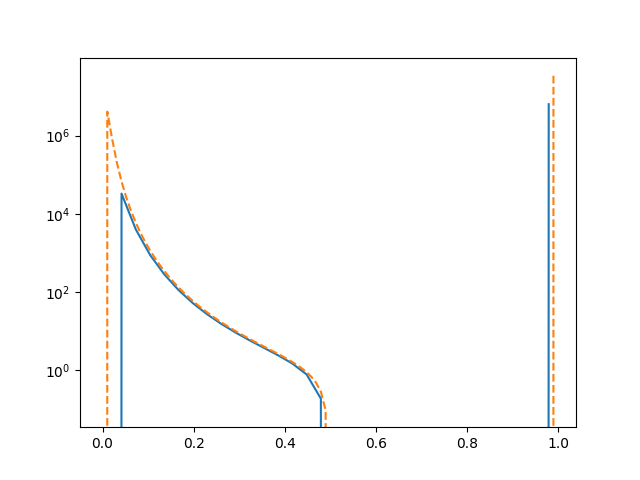

In [36]:
plt.close() 

plt.plot( tt0000.T[0][int(Lx/3):2*int(Lx/3)]/Lx, TxxTxy.T[6][int(Lx/3):2*int(Lx/3)], label="numeric")
plt.plot( TTconn_analytic.T[0][Lx:2*Lx], -2.0 * np.imag(TTconn_analytic.T[2][Lx:2*Lx]), label="analytic", ls="dashed")

plt.yscale("log")

## $\langle T_\nu \rangle$

$$
\langle T \rangle_\nu
=
{1\over 2}
\langle :\hspace{-0.2em}\eta \partial \eta \hspace{-0.2em}: \rangle_\nu
=
-(1/4)e_{\nu-1}
$$

In [10]:
tvev00 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"t_vev00.dat")
tvev01 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"t_vev01.dat")
tvev02 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"t_vev02.dat")

tvev10 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"t_vev10.dat")
tvev11 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"t_vev11.dat")
tvev12 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"t_vev12.dat")

tvev20 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"t_vev20.dat")
tvev21 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"t_vev21.dat")
tvev22 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"t_vev22.dat")

FileNotFoundError: ../data/Lx3Ly6nu2t_vev00.dat not found.

In [14]:
print(e1, e2, e3)

(6.579736267392905+1.0957462049796782e-15j) (-3.2898681338171043+7.304974984485123e-16j) (-3.2898681335758004-1.8262437034281903e-15j)


In [15]:
tA = tvev00 - 0.5*(tvev01+tvev02)
tB = tvev11 - 0.5*(tvev12+tvev10)
tC = tvev22 - 0.5*(tvev20+tvev21)

NameError: name 'tvev00' is not defined

In [ ]:
print(tA[0], tB[0], tC[0])

In [16]:
print(tA[0], tC[0]-tB[0])

NameError: name 'tA' is not defined

In [17]:
Txx = -(2.0*np.pi) * 1.0/3.0 * (tB[0]+tC[0]-2.0*tA[0])/(3.0*alat)/r**2

TxxAlt = -(2.0*np.pi) * (tA[0])/(3.0*alat)/r**2

Txy = 1.0/np.sqrt(3.0) * (2.0*np.pi) * (tC[0]-tB[0])/(3.0*alat)/r**2

NameError: name 'tB' is not defined

In [18]:
0.5 * (Txx - 1.0j*Txy)

NameError: name 'Txx' is not defined

In [19]:
-0.25*e2

(0.8224670334542761-1.8262437461212809e-16j)

CHECK OPE

In [85]:
def TTconnSing(z):
    return 1.0/24.0 * ddP(z) - 0.5*e2*P(z)

def diff(z): return TTconn( z ) - TTconnSing( z )

In [101]:
TTconnSing(zz)

(-624.4707957426644-90.50098966770514j)

In [100]:
zz

(0.1+0.1j)

In [98]:
ddP(zz)

(-14987.123468947486+2.4104799232480962j)

In [86]:
[diff( zz ) for zz in np.arange(0.0, 1.0, 0.1)]

[(9.134385233318143e+46-3.6537540933272573e+47j),
 (4.270750111588313-1.333328578838635e-12j),
 (4.270750111581407-1.9667675099043132e-13j),
 (4.270750111581123-6.715047274608032e-14j),
 (4.270750111581101-2.845978330091534e-14j),
 (4.270750111581055-1.785058403372245e-14j),
 (4.270750111581073-3.7954895434910093e-14j),
 (4.270750111581144-4.392385486473281e-14j),
 (4.27075011158135-1.3487667918956254e-13j),
 (4.270750111581947-2.8316084626075196e-12j)]

In [87]:
g2 = 2.0*(e1**2 + e2**2 + e3**2)

In [88]:
g2

(130.4642309338398-6.507084611880289e-14j)

In [89]:
vev = -0.25*e2

pii_de2 = e2**2 - g2/6.0 -2.0*eta1*e2
pii_dvev = -0.25 * pii_de2

In [90]:
pii_dvev

(-0.8517364297089043-6.2609891329414605e-15j)

In [91]:
C1 = 4.0*eta1 * vev
C2 = 2.0*pii_dvev
C3 = (2.0*np.pi)**2 / 48.0 * vev
C4 = -vev**2

In [103]:
C2

(-1.7034728594178086-1.2521978265882921e-14j)

In [93]:
C4

(-0.8251586416132067-4.586785904913629e-16j)

In [94]:
C1+C2

(4.270750111580994-9.091999233831144e-15j)

In [96]:
TTconnSing(zz)

(-624.4707957426644-90.50098966770514j)

In [97]:
e2

(-3.63352972546136-1.0098799242560166e-15j)

In [56]:
np.exp( 2.0*np.pi*tau * ( eta1/(2.0*np.pi) - 0.25 / np.imag(tau) ) )

(1497.999770766009+162.9918244034058j)

In [42]:
q = np.exp( 2.0*np.pi*1.0j*tau )

In [55]:
np.abs( q**(-0.25*1.0j*e1) )

0.9999999999999946

In [53]:
np.abs( q**(-0.25*1.0j*e2) )

0.9999999999999851

In [54]:
np.abs( q**(-0.25*1.0j*e3) )

1.00000000000002

In [40]:
np.abs(np.exp( - 1.0/4.0 * 2.0*np.pi*1.0j*tau * e1))

7.457180591041581e+38

In [36]:
np.abs(np.exp(-1.0/4.0 * 2.0*np.pi*1.0j*tau * e2))

3.6619521824271626e-20

In [38]:
np.abs(np.exp(-1.0/4.0 * 2.0*np.pi*1.0j*tau * e3))

3.6619521944477346e-20

In [48]:
4.0 * eta1 * (-0.25*e2) + 2.0*np.pi * (-0.25*1.044645038)

(4.333298382503887+3.429979032051776e-15j)

## $\epsilon \epsilon$

In [101]:
eps = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"eps_corr.dat")

In [102]:
nu

3

In [103]:
tmp = np.array([[ [xx, yy, np.abs( P3(xx+tau*yy) )**2 ] 
                 for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp2 = tmp.flatten()
epseps_analytic=np.array(np.split(tmp2, tmp2.shape[0]/3))

In [104]:
tmpx = eps.T[0]
tmpy = eps.T[1]
tmpzr = eps.T[2]
tmpzi = eps.T[3]
res_ = []

for i in range(len(eps.T[0])):
    res_.append( [ tmpx[i]/Lx, tmpy[i]/Lx, (2.0*np.pi)**2 * (tmpzr[i]+1.0j*tmpzi[i])/r**4 ] )
epseps = np.array(res_)

/tmp/ipykernel_8377/1980585953.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(epseps.T[0], epseps.T[1], np.log(np.real(epseps.T[2])), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_8377/1980585953.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(epseps.T[0], epseps.T[1], np.log(-np.real(epseps.T[2])), c='b', marker='o', label="-", alpha=0.2)
/tmp/ipykernel_8377/1980585953.py:22: RuntimeWarning: invalid value encountered in log
  np.log(np.real(-epseps_analytic.T[2])), c='b', marker='o', label="-", alpha=0.2)


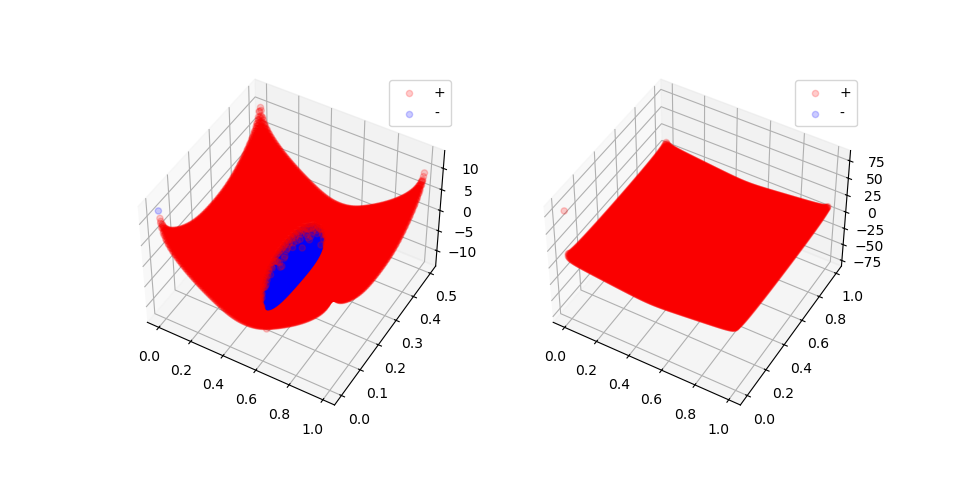

In [107]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=45., azim=-60)

ax.scatter(epseps.T[0], epseps.T[1], np.log(np.real(epseps.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(epseps.T[0], epseps.T[1], np.log(-np.real(epseps.T[2])), c='b', marker='o', label="-", alpha=0.2)
# ax.set_zlim( -5, 5)

ax.legend()

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=45., azim=-60)
ax.scatter(epseps_analytic.T[0], epseps_analytic.T[1], 
           np.log(np.real(epseps_analytic.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(epseps_analytic.T[0], epseps_analytic.T[1], 
           np.log(np.real(-epseps_analytic.T[2])), c='b', marker='o', label="-", alpha=0.2)
# ax.set_zlim( -5, 5)

ax.legend()

# #################

# fig.tight_layout()

# plt.savefig('../plt/re_xixi_above.pdf',bbox_inches='tight')

/tmp/ipykernel_8377/749003900.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(epseps.T[0], epseps.T[1], np.log(np.real(epseps.T[2])), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_8377/749003900.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(epseps.T[0], epseps.T[1], np.log(-np.real(epseps.T[2])), c='b', marker='o', label="-", alpha=0.2)
/tmp/ipykernel_8377/749003900.py:22: RuntimeWarning: invalid value encountered in log
  np.log(np.real(-epseps_analytic.T[2])), c='b', marker='o', label="-", alpha=0.2)


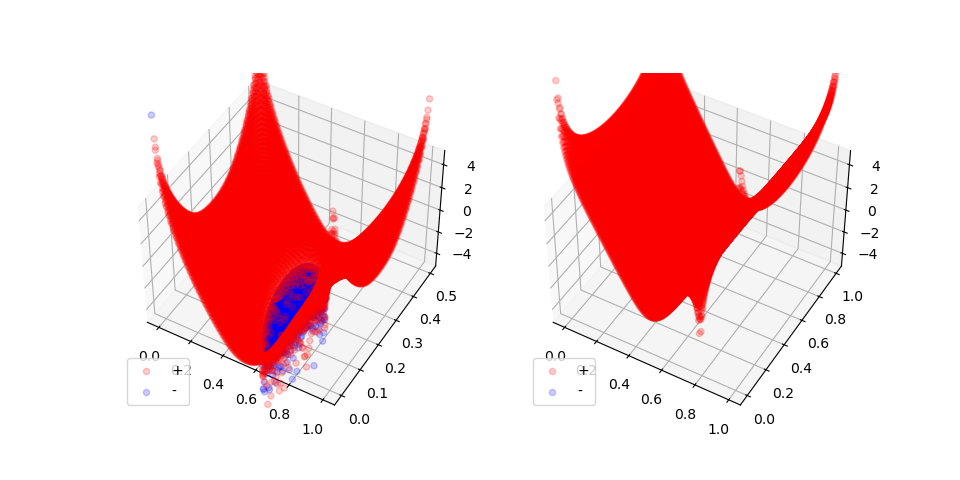

In [108]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=45., azim=-60)

ax.scatter(epseps.T[0], epseps.T[1], np.log(np.real(epseps.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(epseps.T[0], epseps.T[1], np.log(-np.real(epseps.T[2])), c='b', marker='o', label="-", alpha=0.2)
ax.set_zlim( -5, 5)

ax.legend()

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=45., azim=-60)
ax.scatter(epseps_analytic.T[0], epseps_analytic.T[1], 
           np.log(np.real(epseps_analytic.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(epseps_analytic.T[0], epseps_analytic.T[1], 
           np.log(np.real(-epseps_analytic.T[2])), c='b', marker='o', label="-", alpha=0.2)
ax.set_zlim( -5, 5)

ax.legend()

# #################

# fig.tight_layout()

# plt.savefig('../plt/re_xixi_above.pdf',bbox_inches='tight')

In [109]:
# plt.close()
# fig = plt.figure(figsize=plt.figaspect(0.5))

# #################

# ax = fig.add_subplot(121, projection='3d')
# ax.view_init(elev=90., azim=90)

# ax.scatter(etaeta.T[0], etaeta.T[1], np.log(np.imag(etaeta.T[2])), c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(etaeta.T[0], etaeta.T[1], np.log(-np.imag(etaeta.T[2])), c='b', marker='o', label="-", alpha=0.2)
# ax.set_zlim( -5, 5)

# ax.legend()

# #################

# ax = fig.add_subplot(122, projection='3d')
# ax.view_init(elev=90., azim=90)
# ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
#            np.log(np.imag(etaeta_analytic.T[2])), c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
#            np.log(np.imag(-etaeta_analytic.T[2])), c='b', marker='o', label="-", alpha=0.2)
# ax.set_zlim( -5, 5)

# ax.legend()

# #################

# fig.tight_layout()

# plt.savefig('../plt/im_xixi_above.pdf',bbox_inches='tight')

/tmp/ipykernel_8377/3531327105.py:19: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 5.0e3)


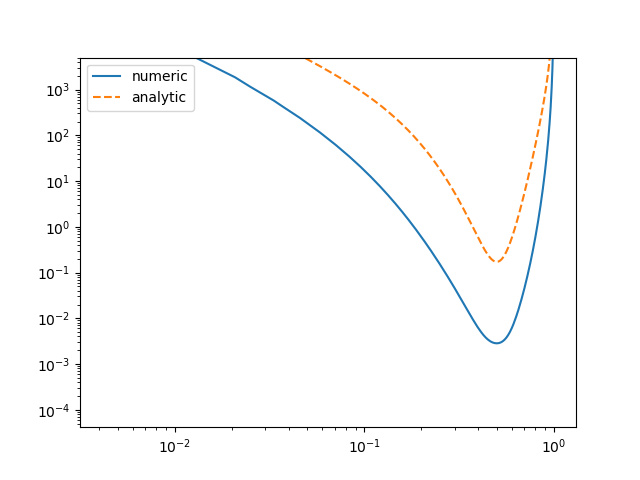

In [110]:
plt.close()

plt.plot( 
    epseps.T[0][:int(2*Lx/3)], 
    epseps.T[2][:int(2*Lx/3)],
    label="numeric"
        )

plt.plot(
    epseps_analytic.T[0][:int(Lx)], 
    epseps_analytic.T[2][:int(Lx)],
    label="analytic", 
    ls="dashed"
)

plt.yscale("log")
plt.legend()

plt.ylim(0, 5.0e3)

plt.xscale("log")
plt.yscale("log")

# plt.savefig('../plt/xixi_slice.pdf',bbox_inches='tight')

In [63]:
m0.000000Lx96Ly192alat0.010000nu3 Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"

SyntaxError: invalid decimal literal (3646259816.py, line 1)

## $TT$ v2

In [60]:
K0K0 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K0K0.dat")
K0K1 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K0K1.dat")
K0K2 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K0K2.dat")
#
K1K0 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K1K0.dat")
K1K1 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K1K1.dat")
K1K2 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K1K2.dat")
#
K2K0 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K2K0.dat")
K2K1 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K2K1.dat")
K2K2 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K2K2.dat")

##

K0E = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K0E.dat")
K1E = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K1E.dat")
K2E = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K2E.dat")
#
K0E0 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K0E0.dat")
K1E0 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K1E0.dat")
K2E0 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K2E0.dat")
#
K0E1 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K0E1.dat")
K1E1 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K1E1.dat")
K2E1 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K2E1.dat")
#
K0E2 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K0E2.dat")
K1E2 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K1E2.dat")
K2E2 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K2E2.dat")

##

EK0 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"EK0.dat")
EK1 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"EK1.dat")
EK2 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"EK2.dat")
#
E0K0 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E0K0.dat")
E0K1 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E0K1.dat")
E0K2 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E0K2.dat")
#
E1K0 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E1K0.dat")
E1K1 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E1K1.dat")
E1K2 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E1K2.dat")
#
E2K0 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E2K0.dat")
E2K1 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E2K1.dat")
E2K2 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E2K2.dat")

##

E0E = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E0E.dat")
E1E = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E1E.dat")
E2E = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E2E.dat")
#
EE0 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"EE0.dat")
EE1 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"EE1.dat")
EE2 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"EE2.dat")
#
EE = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"EE.dat")

##

E0E0 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E0E0.dat")
E0E1 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E0E1.dat")
E0E2 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E0E2.dat")
#
E1E0 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E1E0.dat")
E1E1 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E1E1.dat")
E1E2 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E1E2.dat")
#
E2E0 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E2E0.dat")
E2E1 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E2E1.dat")
E2E2 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E2E2.dat")

In [61]:
tmp = np.array([[ [xx, yy, TTconn(xx+tau*yy) ] for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp2 = tmp.flatten()
TTconn_analytic=np.array(np.split(tmp2, tmp2.shape[0]/3))

In [62]:
Tn0Tn0 = K0K0 - 0.5*(K0E+K0E0) - 0.5*(EK0+E0K0) + 0.25*(EE+EE0+E0E+E0E0)
TnxxTnxx = (2.0*np.pi)**2 * 1.0 / alat**2 * 1.0/r**4 * np.array(Tn0Tn0)

In [63]:
Tn0Tn1 = K0K1 - 0.5*(K0E+K0E1) - 0.5*(EK1+E0K1) + 0.25*(EE+EE1+E0E+E0E1)
Tn0Tn2 = K0K2 - 0.5*(K0E+K0E2) - 0.5*(EK2+E0K2) + 0.25*(EE+EE2+E0E+E0E2)
TnxxTnxy = (2.0*np.pi)**2 * 1.0 / (np.sqrt(3.0) * alat**2) * 1.0/r**4 * (np.array(Tn0Tn2) - np.array(Tn0Tn1))

/tmp/ipykernel_8370/272587844.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(TnxxTnxx.T[2]), c='b', marker='o', label="+")
/tmp/ipykernel_8370/272587844.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(-TnxxTnxx.T[2]), c='r', marker='o', label="-")
/tmp/ipykernel_8370/272587844.py:23: RuntimeWarning: invalid value encountered in log
  ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.real(TTconn_analytic.T[2])),
/tmp/ipykernel_8370/272587844.py:25: RuntimeWarning: invalid value encountered in log
  ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.real(TTconn_analytic.T[2])),


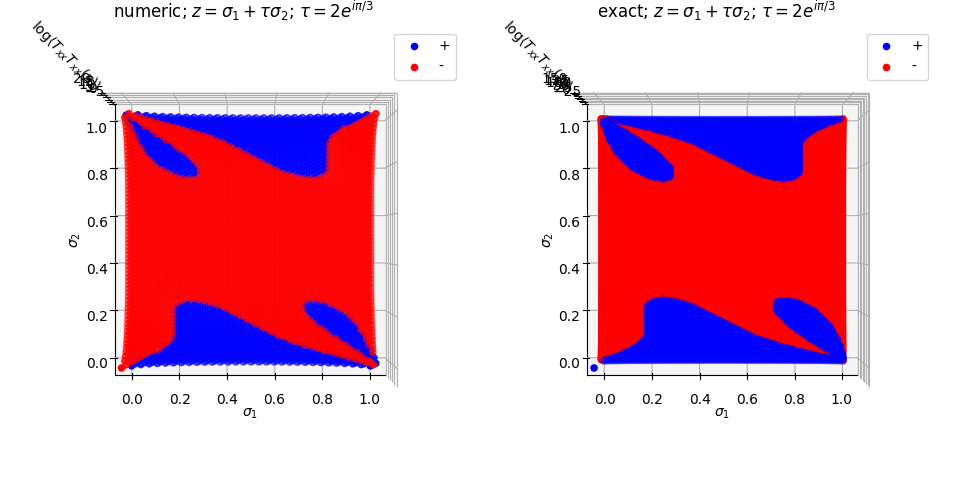

In [64]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(TnxxTnxx.T[2]), c='b', marker='o', label="+")
ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(-TnxxTnxx.T[2]), c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.real(TTconn_analytic.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.real(TTconn_analytic.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

#################

fig.tight_layout()
# plt.savefig('../plt/TxxTxx_above.pdf',bbox_inches='tight')

/tmp/ipykernel_8370/3931763048.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(TnxxTnxx.T[2]), c='b', marker='o', label="+")
/tmp/ipykernel_8370/3931763048.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(-TnxxTnxx.T[2]), c='r', marker='o', label="-")
/tmp/ipykernel_8370/3931763048.py:24: RuntimeWarning: invalid value encountered in log
  ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.real(TTconn_analytic.T[2])),
/tmp/ipykernel_8370/3931763048.py:26: RuntimeWarning: invalid value encountered in log
  ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.real(TTconn_analytic.T[2])),


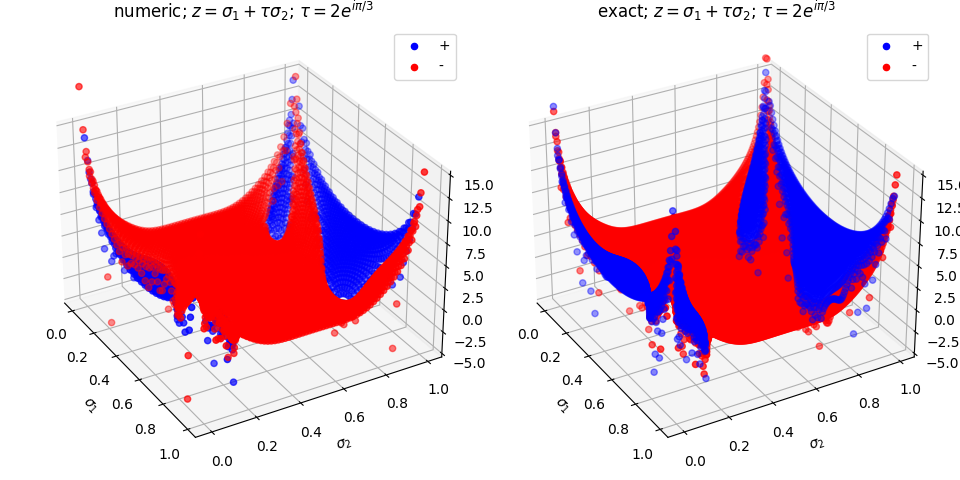

In [67]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=30., azim=-30)

ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(TnxxTnxx.T[2]), c='b', marker='o', label="+")
ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(-TnxxTnxx.T[2]), c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim( -5, 15)

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=30., azim=-30)

ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.real(TTconn_analytic.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.real(TTconn_analytic.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim( -5, 15)

#################

fig.tight_layout()
# plt.savefig('../plt/TxxTxx_above.pdf',bbox_inches='tight')

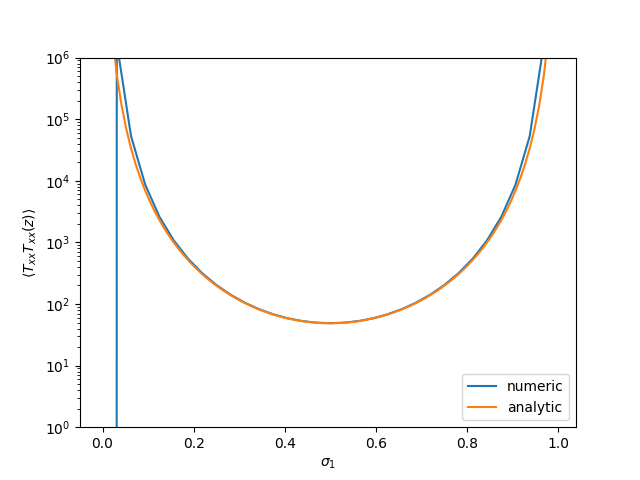

In [68]:
plt.close()

plt.plot( K0K0.T[0][:int(Lx/3)]/Lx, TnxxTnxx.T[2][:int(Lx/3)], label="numeric")
plt.plot( TTconn_analytic.T[0][:Lx], 2.0 * np.real(TTconn_analytic.T[2][:Lx]), label="analytic")

plt.ylim(1.0,1.0e6)
plt.legend()

plt.xlabel("$\\sigma_1$")
plt.ylabel("$\\langle T_{xx}T_{xx}(z) \\rangle$")

plt.yscale("log")
# plt.savefig('../plt/TxxTxx_slice.pdf',bbox_inches='tight')

/tmp/ipykernel_8370/1222106520.py:9: RuntimeWarning: divide by zero encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(TnxxTnxy.T[2]), c='b', marker='o', label="+")
/tmp/ipykernel_8370/1222106520.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(TnxxTnxy.T[2]), c='b', marker='o', label="+")
/tmp/ipykernel_8370/1222106520.py:10: RuntimeWarning: divide by zero encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(-TnxxTnxy.T[2]), c='r', marker='o', label="-")
/tmp/ipykernel_8370/1222106520.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(-TnxxTnxy.T[2]), c='r', marker='o', label="-")
/tmp/ipykernel_8370/1222106520.py:23: RuntimeWarning: invalid value encountered in log
  ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])),
/tmp/ipykernel_8370/1222106520.py:25: RuntimeWarning: invalid value encountered in log

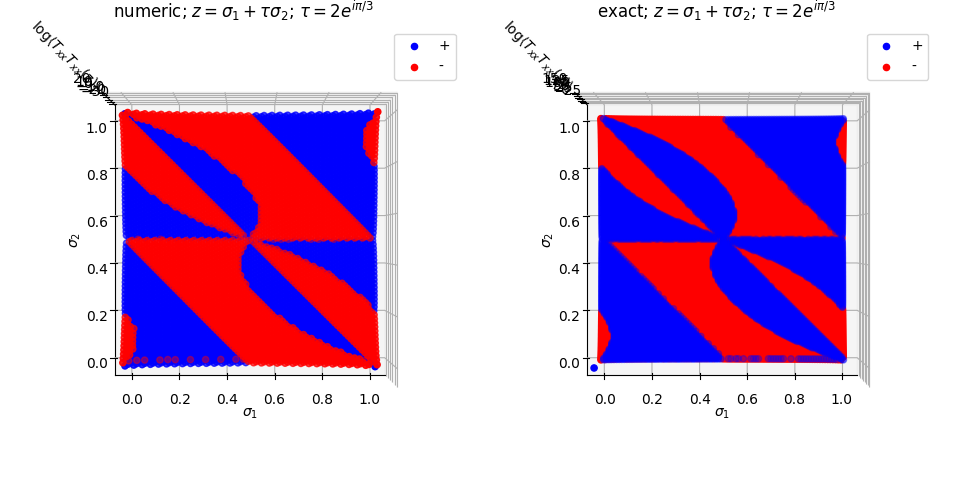

In [69]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(TnxxTnxy.T[2]), c='b', marker='o', label="+")
ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(-TnxxTnxy.T[2]), c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.imag(TTconn_analytic.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

#################

fig.tight_layout()
# plt.savefig('../plt/TxxTxx_above.pdf',bbox_inches='tight')

/tmp/ipykernel_8370/3324861242.py:9: RuntimeWarning: divide by zero encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(TnxxTnxy.T[2]), c='b', marker='o', label="+")
/tmp/ipykernel_8370/3324861242.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(TnxxTnxy.T[2]), c='b', marker='o', label="+")
/tmp/ipykernel_8370/3324861242.py:10: RuntimeWarning: divide by zero encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(-TnxxTnxy.T[2]), c='r', marker='o', label="-")
/tmp/ipykernel_8370/3324861242.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(-TnxxTnxy.T[2]), c='r', marker='o', label="-")
/tmp/ipykernel_8370/3324861242.py:24: RuntimeWarning: invalid value encountered in log
  ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])),
/tmp/ipykernel_8370/3324861242.py:26: RuntimeWarning: invalid value encountered in log

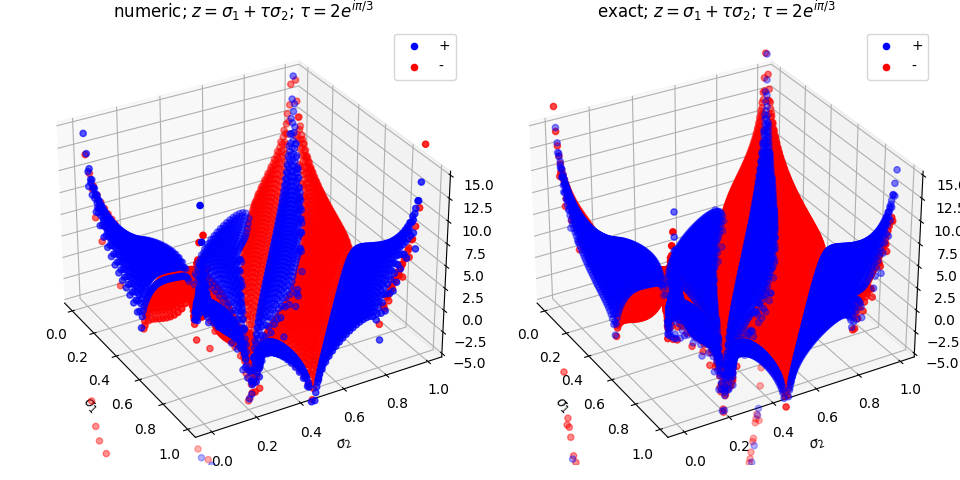

In [70]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=30., azim=-30)

ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(TnxxTnxy.T[2]), c='b', marker='o', label="+")
ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(-TnxxTnxy.T[2]), c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim( -5, 15)

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=30., azim=-30)

ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.imag(TTconn_analytic.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim( -5, 15)

#################

fig.tight_layout()
# plt.savefig('../plt/TxxTxx_above.pdf',bbox_inches='tight')

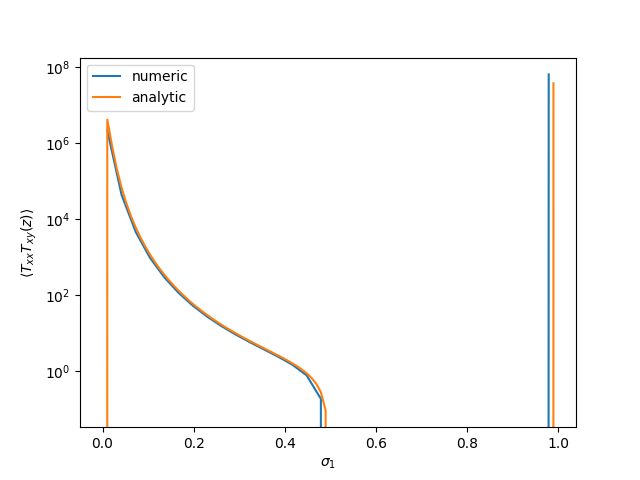

In [71]:
plt.close()

plt.plot( K0K0.T[0][int(Lx/3):2*int(Lx/3)]/Lx, TnxxTnxy.T[2][int(Lx/3):2*int(Lx/3)], label="numeric")
plt.plot( TTconn_analytic.T[0][:Lx], -2.0 * np.imag(TTconn_analytic.T[2][Lx:2*Lx]), label="analytic")

# plt.ylim(1.0,1.0e6)
plt.legend()

plt.xlabel("$\\sigma_1$")
plt.ylabel("$\\langle T_{xx}T_{xy}(z) \\rangle$")

plt.yscale("log")
# plt.savefig('../plt/TxxTxx_slice.pdf',bbox_inches='tight')

## $\langle T_\nu \rangle$ v2

$$
\langle T \rangle_\nu
=
{1\over 2}
\langle :\hspace{-0.2em}\eta \partial \eta \hspace{-0.2em}: \rangle_\nu
=
-(1/4)e_{\nu-1}
$$

In [62]:
nu = 1

# Lx = 6
# Ly = 12

In [63]:
t0 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"t_vev_v2_0.dat")
t1 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"t_vev_v2_1.dat")
t2 = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"t_vev_v2_2.dat")

# eps_vev = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"eps_vev.dat")

In [64]:
print(nu, t0[0], t1[0], t2[0])
t0_2 = t0[0]
t1_2 = t1[0]
t2_2 = t2[0]
Tnu2=(t1[0]+t2[0]-2.0*t0[0])

1 0.2520834486391117 0.2520834486391117 0.2458331027217782


In [61]:
print(nu, t0[0], t1[0], t2[0])
t0_3 = t0[0]
t1_3 = t1[0]
t2_3 = t2[0]
Tnu3=(t1[0]+t2[0]-2.0*t0[0])

2 0.2479165513608861 0.2479165513608864 0.2541668972782204


In [58]:
print(nu, t0[0], t1[0], t2[0])
t0_4 = t0[0]
t1_4 = t1[0]
t2_4 = t2[0]
Tnu4=(t1[0]+t2[0]-2.0*t0[0])

3 0.2474166985829786 0.2474166985829789 0.2551666028340425


In [44]:
# numer =  t0_2*np.abs(th20) + t0_3*np.abs(th30) + t0_4*np.abs(th40)
# denom = np.abs(th20) + np.abs(th30) + np.abs(th40)
# numer/denom

In [36]:
N0 = Lx*Ly*2/3

# 3*3
# Z1p = 4.000000000000002e+00
# Z2 = 1.481481481481481e+00
# Z3 = 1.481481481481481e+00
# Z4 = 1.481481481481481e+00

# # 3*6
# Z1p = 5.925925925925926e+00
# Z2 = 1.141289437585736e+00
# Z3 = 2.150891632373100e+00
# Z4 = 2.194787379972571e+00

# # 6*12
# logabsdet1p = -8.154754154898682e-01
# logabsdet2 = 2.244999998307738e+00
# logabsdet3 = 3.557138050954424e+00
# logabsdet4 = 3.592164710856971e+00

# Z1p = np.sqrt( np.exp(logabsdet1p-logabsdet3) )
# Z2 = np.sqrt( np.exp(logabsdet2-logabsdet3) )
# Z3 = 1.0
# Z4 = np.sqrt( np.exp(logabsdet4-logabsdet3) )


# 9*12
logabsdet1p = 3.127889014800901e-01
logabsdet2 = 4.181035532995615e+00
logabsdet3 = 4.556965367447633e+00
logabsdet4 = 4.663174907386211e+00

Z1p = np.sqrt( np.exp(logabsdet1p-logabsdet3) )
Z2 = np.sqrt( np.exp(logabsdet2-logabsdet3) )
Z3 = 1.0
Z4 = np.sqrt( np.exp(logabsdet4-logabsdet3) )



# # 12*24
# logabsdet1p = 5.806238622389490e+00
# logabsdet2 = 1.025295710096546e+01
# logabsdet3 = 1.156958560491853e+01
# logabsdet4 = 1.160427609852433e+01

# Z1p = np.sqrt( np.exp(logabsdet1p-logabsdet3) )
# Z2 = np.sqrt( np.exp(logabsdet2-logabsdet3) )
# Z3 = 1.0
# Z4 = np.sqrt( np.exp(logabsdet4-logabsdet3) )



# # 12*18
# logabsdet1p = 3.589669447746418e+00
# logabsdet2 = 8.036233573071623e+00
# logabsdet3 = 8.642451948357818e+00
# logabsdet4 = 8.738000900443257e+00

# Z1p = np.sqrt( np.exp(logabsdet1p-logabsdet3) )
# Z2 = np.sqrt( np.exp(logabsdet2-logabsdet3) )
# Z3 = 1.0
# Z4 = np.sqrt( np.exp(logabsdet4-logabsdet3) )



# # 24*36
# logabsdet1p = 2.623376714737932e+01
# logabsdet2 = 3.206662599312489e+01
# logabsdet3 = 3.267308662913767e+01
# logabsdet4 = 3.276859577460962e+01

# Z1p = np.sqrt( np.exp(logabsdet1p-logabsdet3) )
# Z2 = np.sqrt( np.exp(logabsdet2-logabsdet3) )
# Z3 = 1.0
# Z4 = np.sqrt( np.exp(logabsdet4-logabsdet3) )


# # 6*6
# Z1p = 1.300614743687452e+01
# Z2 = 2.454789901419004e+00
# Z3 = 2.454789901418974e+00
# Z4 = 2.454789901418971e+00

# # 24*48
# logabsdet1p = 3.646046870455798e+01
# logabsdet2 = 4.229347864476325e+01
# logabsdet3 = 4.361041578869611e+01
# logabsdet4 = 4.364508541176799e+01

# Z1p = np.sqrt( np.exp(logabsdet1p-logabsdet3) )
# Z2 = np.sqrt( np.exp(logabsdet2-logabsdet3) )
# Z3 = 1.0
# Z4 = np.sqrt( np.exp(logabsdet4-logabsdet3) )

In [37]:
denom = Z2 + Z3 + Z4

In [38]:
numer0 = 1.0/N0 * Z1p + t0_2*Z2 + t0_3*Z3 + t0_4*Z4
t0est = numer0/denom

In [39]:
numer1 = 1.0/N0 * Z1p + t1_2*Z2 + t1_3*Z3 + t1_4*Z4
t1est = numer1/denom

In [40]:
numer2 = 1.0/N0 * Z1p + t2_2*Z2 + t2_3*Z3 + t2_4*Z4
t2est = numer2/denom

In [41]:
print(t0est, t1est, t2est)

0.24997608195761356 0.249976081957614 0.2500543274563899


$\nu=2$ sector

In [42]:
Tnxx2 = -(2.0*np.pi) * 1.0/3.0 * (t1_2+t2_2-2.0*t0_2)/alat/r**2
Tnxy2 = 1.0/np.sqrt(3.0) * (2.0*np.pi) * (t2_2-t1_2)/alat/r**2

In [43]:
0.5 * (Tnxx2 - 1.0j*Tnxy2)

(-1.8165969399783015-3.1464381968752733j)

In [44]:
-0.25*e1

(-1.474585992371192-2.5540578589162806j)

$\nu=3$ sector

In [50]:
Tnxx3 = -(2.0*np.pi) * 1.0/3.0 * (t1_3+t2_3-2.0*t0_3)/alat/r**2
Tnxy3 = 1.0/np.sqrt(3.0) * (2.0*np.pi) * (t2_3-t1_3)/alat/r**2

In [51]:
0.5 * (Tnxx3 - 1.0j*Tnxy3)

(-1.8165969399783015-3.1464381968752733j)

In [52]:
-0.25*e2

(-1.81676486273068-3.1467290476554353j)

$\nu=4$ sector

In [48]:
Tnxx4 = (2.0*np.pi) * 1.0/3.0 * (2.0*t0_4-t1_4-t2_4)/alat/r**2
Tnxy4 = (2.0*np.pi) * 1.0/np.sqrt(3.0) * (t2_4-t1_4)/alat/r**2

In [49]:
0.5 * (Tnxx4 - 1.0j*Tnxy4)

(-1.816596939977657-3.146438196875273j)

In [77]:
-0.25*e3

(0.554637808719709+0.442304746895251j)

In [45]:
numerxx = Tnxx2*Z2 + Tnxx3*Z3 + Tnxx4*Z4
numerxy = Tnxy2*Z2 + Tnxy3*Z3 + Tnxy4*Z4

print(numerxx/denom)
print(numerxy/denom)

NameError: name 'Tnxx2' is not defined

In [69]:
t2est-t1est

-0.00011020203752937219

In [70]:
(2.0*np.pi) * 1.0/3.0 * (t1est+t2est-2.0*t0est)/alat/r**2

-0.20110475455572577

In [71]:
t1est+t2est-2.0*t0est

-0.0030798572831466364

In [53]:
Z2 / Z3

0.828643777845116

In [97]:
e1

(6.579723417124579-0.04504699636035683j)

In [ ]:
Z1p = np.sqrt( np.exp(logabsdet1p-logabsdet3) )
Z2 = np.sqrt( np.exp(logabsdet2-logabsdet3) )
Z3 = 1.0
Z4 = np.sqrt( np.exp(logabsdet4-logabsdet3) )

In [77]:
eps_vev

array([-1.5000000e+00,  1.6368777e-18])

In [46]:
print(e1, e2, e3)

(5.898343969484768+10.216231435665122j) (7.26705945092272+12.586916190621741j) (-13.16540342040749-22.80314762628686j)


In [57]:
v1 = t1[0]

In [58]:
v2 = 1.0/3.0 * (t1[0]+t2[0]-2.0*t0[0])

In [59]:
v1 + v2

0.25000000000000133

In [52]:
t1[0]+t2[0]-2.0*t0[0]

0.007749904251064255

In [45]:
t1[0]

0.2474166985829789

In [53]:
Tnxx2 = -(2.0*np.pi) * 1.0/3.0 * (t1[0]+t2[0]-2.0*t0[0])/alat/r**2
Tnxx = (2.0*np.pi) * (t0[0]-1/4)/alat/r**2

# TnxxAlt = -(2.0*np.pi) * (t0[0])/(3.0*alat)/r**2

Tnxy = 1.0/np.sqrt(3.0) * (2.0*np.pi) * (t2[0]-t1[0])/alat/r**2

Tnyy = 2.0/3.0 * (2.0*np.pi) * (t2[0]+t1[0]-0.5*t0[0]-3/8)/alat/r**2

In [54]:
Tnyy

3.598533479284841

In [55]:
Tnxx

-3.598533479284815

In [49]:
0.5 * (Tnxx - 1.0j*Tnxy)

(-1.7992667396424076-3.116421409429219j)

In [50]:
-0.25*e2

(-1.81676486273068-3.1467290476554353j)

In [72]:
e1+e2+e3

(-1.7763568394002505e-15+3.552713678800501e-15j)

## Tepseps

In [287]:
nu = 2

In [288]:
K0EE = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K0EE.dat")
K1EE = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K1EE.dat")
K2EE = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"K2EE.dat")

E0EE = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E0EE.dat")
E1EE = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E1EE.dat")
E2EE = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"E2EE.dat")

EEE = np.loadtxt("../data/Lx"+str(Lx)+"Ly"+str(Ly)+"nu"+str(nu)+"EEE.dat")

In [289]:
# tmp = np.array([[ [xx, yy, TTconn(xx+tau*yy) ] for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
# tmp2 = tmp.flatten()
# TTconn_analytic=np.array(np.split(tmp2, tmp2.shape[0]/3))

In [290]:
Tn0EE = -K0EE + 0.5*(E0EE+EEE)
Tn1EE = -K1EE + 0.5*(E1EE+EEE)
Tn2EE = -K2EE + 0.5*(E2EE+EEE)

In [291]:
w1 = -(2.0*np.pi) * 1.0/3.0 /alat/r**2
w2 = (2.0*np.pi)**2 / r**4
ww = w1*w2

In [292]:
TxxEE = ww * ( np.array(Tn1EE) + np.array(Tn2EE) - 2.0*np.array(Tn0EE) )

In [302]:
# def Tepseps_sing2(w0, w1, w2):
#     tmp1 = 0.5/(w0-w1)**2 * P3(w1-w2) * np.conj(P3(w1-w2))
#     tmp2 = 1.0/(w0-w1) * dP3(w1-w2) * np.conj(P3(w1-w2))
#     return tmp1 + tmp2

# def Tepseps_sing3(w0, w1, w2):
#     tmp1 = 0.5 * ( P(w1-w0) + 2.0*eta1 ) * P3(w1-w2) * np.conj(P3(w1-w2))
#     tmp2 = 1.0 * ( - zeta(w1-w0) + 2.0*eta1*(w1-w0) + np.pi*1.0j ) * dP3(w1-w2) * np.conj(P3(w1-w2))
#     return tmp1 + tmp2

In [303]:
# def Tepseps4(w0, w1, w2):
#     tmp1 = 0.5 * ( P(w1-w0) + 2.0*eta1 ) * P3(w1-w2) * np.conj(P3(w1-w2))
#     tmp2 = 1.0 * ( - zeta(w1-w0) + 2.0*eta1*(w1-w0) + np.pi*1.0j ) * dP3(w1-w2) * np.conj(P3(w1-w2))

#     tmp3 = 0.5 * ( P(w2-w0) + 2.0*eta1 ) * P3(w1-w2) * np.conj(P3(w1-w2))
#     tmp4 = -1.0 * ( - zeta(w2-w0) + 2.0*eta1*(w2-w0) + np.pi*1.0j ) * dP3(w1-w2) * np.conj(P3(w1-w2))
#     return tmp1 + tmp2 + tmp3 + tmp4

In [304]:
# def Tepseps5(w0, w1, w2):

#     p = P3(w1-w2)
#     cp = np.conj(P3(w1-w2))
#     dp = dP3(w1-w2)
#     Dp = DP3(w1-w2)

#     epseps = p*cp

#     tmp1 = 0.5 * ( P(w1-w0) + 2.0*eta1 ) * epseps
#     tmp2 = 1.0 * ( - zeta(w1-w0) + 2.0*eta1*(w1-w0) + np.pi*1.0j ) * dp*cp

#     tmp3 = 0.5 * ( P(w2-w0) + 2.0*eta1 ) * epseps
#     tmp4 = -1.0 * ( - zeta(w2-w0) + 2.0*eta1*(w2-w0) + np.pi*1.0j ) * dp*cp

#     tmp5 = 2.0*np.pi*1.0j * Dp*cp

#     tmp6 = -0.25*e3 * epseps
    
#     # return tmp1 + tmp2 + tmp3 + tmp4 + tmp5 + tmp6
#     return tmp1 + tmp2 + tmp3 + tmp4 + tmp5

In [309]:
tmp = np.array([[ [xx, yy, Tepseps2_analytic(0.0, 1.0/3+1/Lx, xx+tau*yy) ] 
                 for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp5 = tmp.flatten()
Tepseps_5 = np.array(np.split(tmp5, tmp5.shape[0]/3))

In [311]:
tmp = np.array([[ [xx, yy, Tepseps2_analytic2(0.0, 1.0/3+1/Lx, xx+tau*yy) ] 
                 for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp51 = tmp.flatten()
Tepseps_51 = np.array(np.split(tmp51, tmp51.shape[0]/3))

In [ ]:
tmp = np.array([[ [xx, yy, Tepseps3_analytic(0.0, 1.0/3+1/Lx, xx+tau*yy) ] 
                 for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp5 = tmp.flatten()
Tepseps_5 = np.array(np.split(tmp5, tmp5.shape[0]/3))

In [ ]:
tmp = np.array([[ [xx, yy, Tepseps4_analytic(0.0, 1.0/3+1/Lx, xx+tau*yy) ] 
                 for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp5 = tmp.flatten()
Tepseps_5 = np.array(np.split(tmp5, tmp5.shape[0]/3))

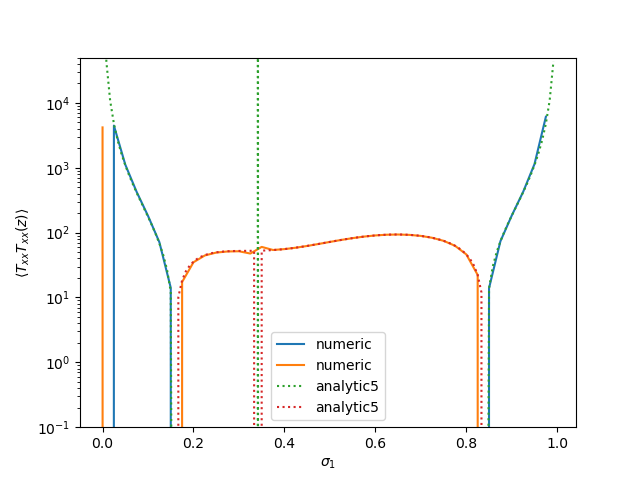

In [314]:
plt.close()

plt.plot( (K0EE.T[0]/Lx)[:int(Lx/3)], -TxxEE.T[2][:int(Lx/3)], label="numeric")
plt.plot( (K0EE.T[0]/Lx)[:int(Lx/3)], TxxEE.T[2][:int(Lx/3)], label="numeric")
# plt.plot( Tepseps2.T[0][:Lx], np.real(2.0*Tepseps2.T[2][:Lx]), label="analytic2", ls="dashed")
# plt.plot( Tepseps_6.T[0][:Lx], np.real(2.0*Tepseps_6.T[2][:Lx]), label="analytic6", ls="dashed")

plt.plot( Tepseps_5.T[0][:Lx], np.real(2.0*Tepseps_5.T[2][:Lx]), label="analytic5", ls="dotted")
plt.plot( Tepseps_5.T[0][:Lx], np.real(-2.0*Tepseps_5.T[2][:Lx]), label="analytic5", ls="dotted")

# plt.plot( Tepseps_5.T[0][:Lx], np.real(2.0*Tepseps_51.T[2][:Lx]), label="analytic5", ls="dotted")
# plt.plot( Tepseps_5.T[0][:Lx], np.real(-2.0*Tepseps_51.T[2][:Lx]), label="analytic5", ls="dotted")

# plt.ylim(1e4,2.0e8)
plt.ylim(1e-1,5.0e4)
# plt.xlim(1.0/Lx, 0.3)
plt.legend()

plt.xlabel("$\\sigma_1$")
plt.ylabel("$\\langle T_{xx}T_{xx}(z) \\rangle$")

plt.yscale("log")
# plt.xscale("log")
# plt.savefig('../plt/TxxTxx_slice.pdf',bbox_inches='tight')

/tmp/ipykernel_93353/3851078341.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(K0EE.T[0]/Lx, K0EE.T[1]/Ly, np.log(TxxEE.T[2]), c='b', marker='o', label="+")
/tmp/ipykernel_93353/3851078341.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(K0EE.T[0]/Lx, K0EE.T[1]/Ly, np.log(-TxxEE.T[2]), c='r', marker='o', label="-")
/tmp/ipykernel_93353/3851078341.py:25: RuntimeWarning: invalid value encountered in log
  ax.scatter(Tepseps_5.T[0], Tepseps_5.T[1], np.log(2.0*np.real(Tepseps_5.T[2])),
/tmp/ipykernel_93353/3851078341.py:27: RuntimeWarning: invalid value encountered in log
  ax.scatter(Tepseps_5.T[0], Tepseps_5.T[1], np.log(-2.0*np.real(Tepseps_5.T[2])),


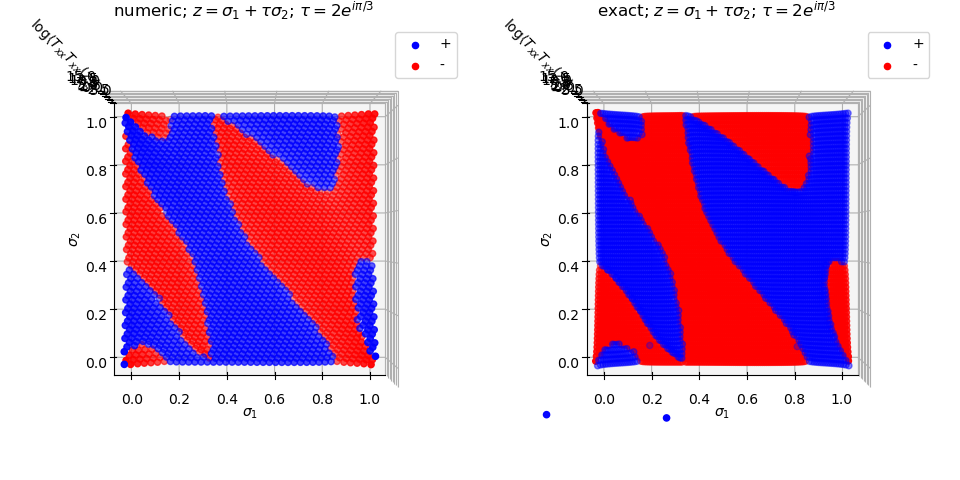

In [313]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(K0EE.T[0]/Lx, K0EE.T[1]/Ly, np.log(TxxEE.T[2]), c='b', marker='o', label="+")
ax.scatter(K0EE.T[0]/Lx, K0EE.T[1]/Ly, np.log(-TxxEE.T[2]), c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

ax.set_zlim(-5.0, 15.0)

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(Tepseps_5.T[0], Tepseps_5.T[1], np.log(2.0*np.real(Tepseps_5.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(Tepseps_5.T[0], Tepseps_5.T[1], np.log(-2.0*np.real(Tepseps_5.T[2])), 
           c='r', marker='o', label="-")
ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

ax.set_zlim(-5.0, 15.0)

#################

fig.tight_layout()
# plt.savefig('../plt/TxxTxx_above.pdf',bbox_inches='tight')

In [37]:
tmp = np.array([[ [xx, yy, 1.0/(xx+tau*yy) ] 
                 for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp2 = tmp.flatten()
z1=np.array(np.split(tmp2, tmp2.shape[0]/3))

tmp = np.array([[ [xx, yy, zeta(xx+tau*yy)-2.0*eta1*(xx+tau*yy) ] 
                 for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp3 = tmp.flatten()
z2=np.array(np.split(tmp3, tmp3.shape[0]/3))

/tmp/ipykernel_85824/2694289963.py:1: RuntimeWarning: divide by zero encountered in scalar divide
  tmp = np.array([[ [xx, yy, 1.0/(xx+tau*yy) ]
/tmp/ipykernel_85824/2694289963.py:1: RuntimeWarning: invalid value encountered in scalar divide
  tmp = np.array([[ [xx, yy, 1.0/(xx+tau*yy) ]


NameError: name 'Tepseps1' is not defined

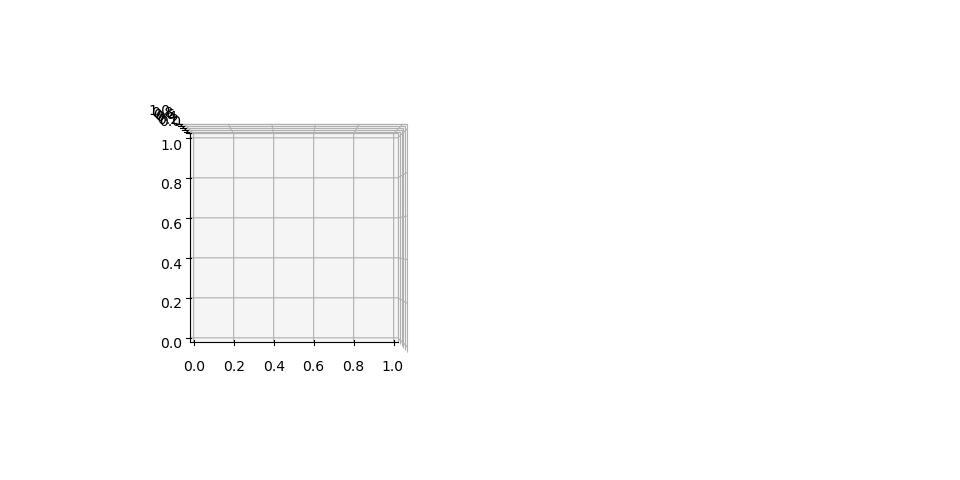

In [38]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(Tepseps1.T[0], Tepseps1.T[1], np.log(2.0*np.real(z1.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(Tepseps1.T[0], Tepseps1.T[1], np.log(-2.0*np.real(z1.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim(-5, 15)

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(Tepseps2.T[0], Tepseps2.T[1], np.log(2.0*np.real(z2.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(Tepseps2.T[0], Tepseps2.T[1], np.log(-2.0*np.real(z2.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim(-5, 15)

#################

fig.tight_layout()
# plt.savefig('../plt/TxxTxx_above.pdf',bbox_inches='tight')

/tmp/ipykernel_85824/848327153.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(Tepseps1.T[0], Tepseps1.T[1], np.log(2.0*np.real(Tepseps1.T[2])),
/tmp/ipykernel_85824/848327153.py:11: RuntimeWarning: invalid value encountered in log
  ax.scatter(Tepseps1.T[0], Tepseps1.T[1], np.log(-2.0*np.real(Tepseps1.T[2])),
/tmp/ipykernel_85824/848327153.py:28: RuntimeWarning: invalid value encountered in log
  ax.scatter(Tepseps2.T[0], Tepseps2.T[1], np.log(-2.0*np.real(Tepseps2.T[2])),


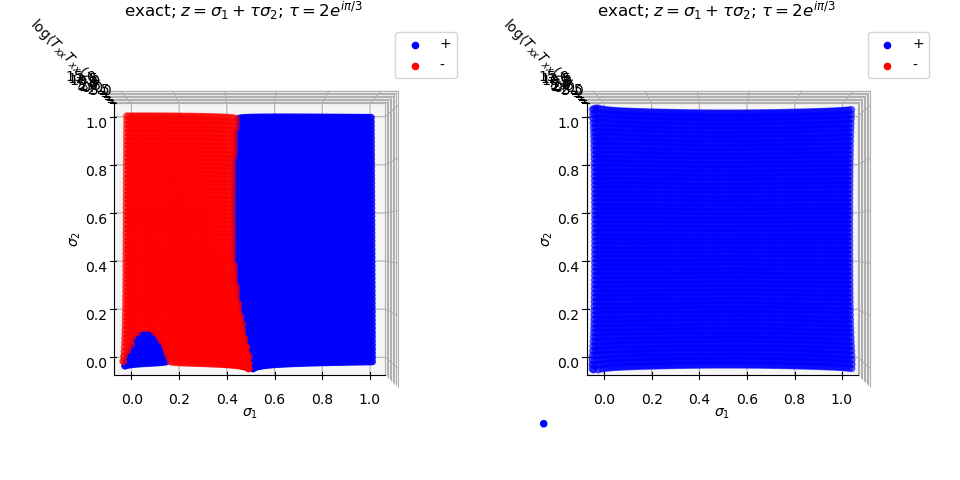

In [55]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(Tepseps1.T[0], Tepseps1.T[1], np.log(2.0*np.real(Tepseps1.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(Tepseps1.T[0], Tepseps1.T[1], np.log(-2.0*np.real(Tepseps1.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim(-5, 15)

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(Tepseps2.T[0], Tepseps2.T[1], np.log(2.0*np.real(Tepseps2.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(Tepseps2.T[0], Tepseps2.T[1], np.log(-2.0*np.real(Tepseps2.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim(-5, 15)

#################

fig.tight_layout()
# plt.savefig('../plt/TxxTxx_above.pdf',bbox_inches='tight')

In [ ]:
# tmp = np.array([[ [xx, yy, (P(0.5) + 2.0*eta1 + P(xx+tau*yy) + 2.0*eta1) * np.abs( P3(xx+tau*yy-0.5) )**2 ] 
#                  for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
# tmp2 = tmp.flatten()

# tmp = np.array([[ [xx, yy, ( -zeta(xx+tau*yy) + 2.0*eta1*( xx+tau*yy ) + np.pi*1.0j) * dP3(xx+tau*yy-0.5)*np.conj(P3(xx+tau*yy-0.5)) ] 
#                  for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
# tmp3 = tmp.flatten()

# tmp = np.array([[ [xx, yy, -( -zeta(0.5) + 2.0*eta1*(0.5) + np.pi*1.0j) * dP3(xx+tau*yy-0.5)*np.conj(P3(xx+tau*yy-0.5)) ] 
#                  for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
# tmp4 = tmp.flatten()

# Tepseps_analytic=np.array(np.split(tmp2-tmp3-tmp4, tmp2.shape[0]/3))

In [63]:
Lx/3

32.0

In [62]:
K0EE.T[0][:K]

array([0., 3., 6.])

In [64]:
(K0EE.T[0]/Lx)[:int(Lx/3)]

array([0.     , 0.03125, 0.0625 , 0.09375, 0.125  , 0.15625, 0.1875 ,
       0.21875, 0.25   , 0.28125, 0.3125 , 0.34375, 0.375  , 0.40625,
       0.4375 , 0.46875, 0.5    , 0.53125, 0.5625 , 0.59375, 0.625  ,
       0.65625, 0.6875 , 0.71875, 0.75   , 0.78125, 0.8125 , 0.84375,
       0.875  , 0.90625, 0.9375 , 0.96875])

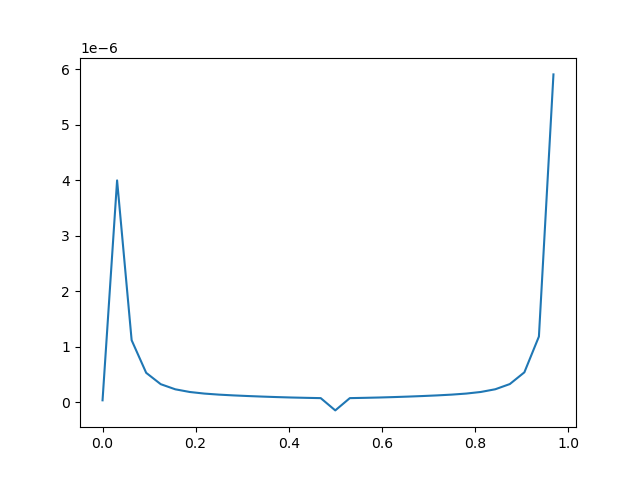

In [73]:
plt.close()
plt.plot( (K0EE.T[0]/Lx)[:int(Lx/3)], TxxEE.T[2][:int(Lx/3)], label="numeric")

/tmp/ipykernel_8370/1222106520.py:9: RuntimeWarning: divide by zero encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(TnxxTnxy.T[2]), c='b', marker='o', label="+")
/tmp/ipykernel_8370/1222106520.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(TnxxTnxy.T[2]), c='b', marker='o', label="+")
/tmp/ipykernel_8370/1222106520.py:10: RuntimeWarning: divide by zero encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(-TnxxTnxy.T[2]), c='r', marker='o', label="-")
/tmp/ipykernel_8370/1222106520.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(-TnxxTnxy.T[2]), c='r', marker='o', label="-")
/tmp/ipykernel_8370/1222106520.py:23: RuntimeWarning: invalid value encountered in log
  ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])),
/tmp/ipykernel_8370/1222106520.py:25: RuntimeWarning: invalid value encountered in log

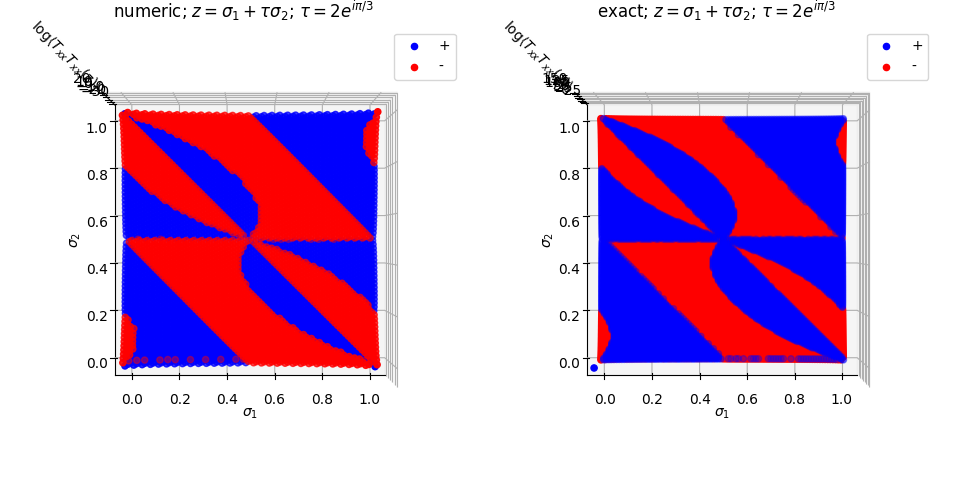

In [69]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(TnxxTnxy.T[2]), c='b', marker='o', label="+")
ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(-TnxxTnxy.T[2]), c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.imag(TTconn_analytic.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

#################

fig.tight_layout()
# plt.savefig('../plt/TxxTxx_above.pdf',bbox_inches='tight')

/tmp/ipykernel_8370/3324861242.py:9: RuntimeWarning: divide by zero encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(TnxxTnxy.T[2]), c='b', marker='o', label="+")
/tmp/ipykernel_8370/3324861242.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(TnxxTnxy.T[2]), c='b', marker='o', label="+")
/tmp/ipykernel_8370/3324861242.py:10: RuntimeWarning: divide by zero encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(-TnxxTnxy.T[2]), c='r', marker='o', label="-")
/tmp/ipykernel_8370/3324861242.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(-TnxxTnxy.T[2]), c='r', marker='o', label="-")
/tmp/ipykernel_8370/3324861242.py:24: RuntimeWarning: invalid value encountered in log
  ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])),
/tmp/ipykernel_8370/3324861242.py:26: RuntimeWarning: invalid value encountered in log

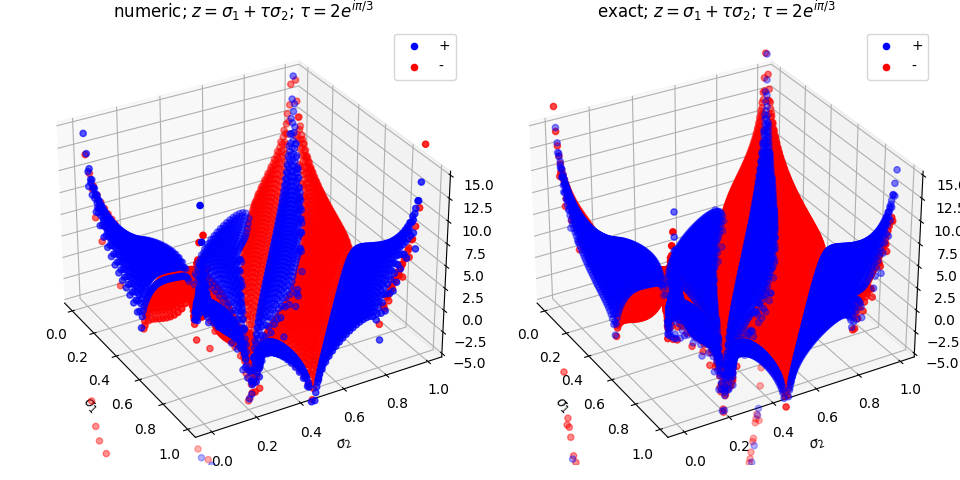

In [70]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=30., azim=-30)

ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(TnxxTnxy.T[2]), c='b', marker='o', label="+")
ax.scatter(K0K0.T[0]/Lx, K0K0.T[1]/Ly, np.log(-TnxxTnxy.T[2]), c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim( -5, 15)

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=30., azim=-30)

ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.imag(TTconn_analytic.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim( -5, 15)

#################

fig.tight_layout()
# plt.savefig('../plt/TxxTxx_above.pdf',bbox_inches='tight')

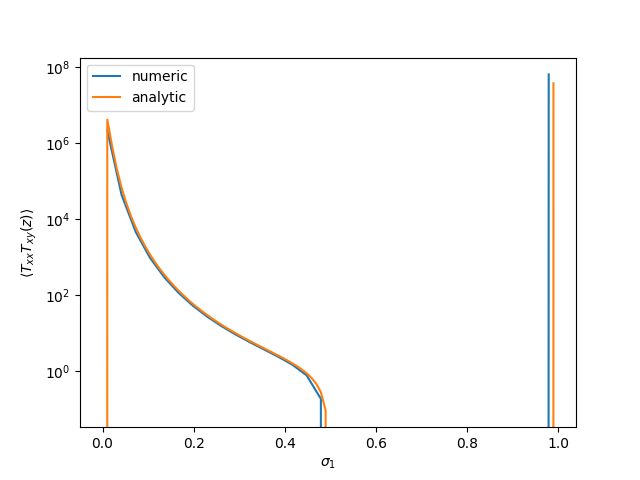

In [71]:
plt.close()

plt.plot( K0K0.T[0][int(Lx/3):2*int(Lx/3)]/Lx, TnxxTnxy.T[2][int(Lx/3):2*int(Lx/3)], label="numeric")
plt.plot( TTconn_analytic.T[0][:Lx], -2.0 * np.imag(TTconn_analytic.T[2][Lx:2*Lx]), label="analytic")

# plt.ylim(1.0,1.0e6)
plt.legend()

plt.xlabel("$\\sigma_1$")
plt.ylabel("$\\langle T_{xx}T_{xy}(z) \\rangle$")

plt.yscale("log")
# plt.savefig('../plt/TxxTxx_slice.pdf',bbox_inches='tight')